# Data Exploration for a Machine Learning Stock Predictor

In [4]:
# import needed libraries
import os
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 15.0)

## Helper functions
---

Global functions intended to make computations and exploration easier.

In [7]:

################################################
# Data Gathering Helpers
################################################
def path_to_data(ticker, base_dir='data'):
    return os.path.join(base_dir, '{}.csv'.format(ticker))

#
# returns the full data set of a single stock for visualization.
#
def example_full_data(ticker, dates):
    df = pd.DataFrame(index=dates)
    df = pd.read_csv(
            path_to_data(ticker), 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
    return df

#
# Takes a list of stock symbols and returns a new data set filtered down to
# the data as an index, the symbols as column names and the values of the columns
# that stocks adjusted closing price.
#
def fetch_data(ticker_list, dates):
    df = pd.DataFrame(index=dates)
    
    if 'SPY' not in ticker_list:
        ticker_list.insert(0, 'SPY')
        
    for ticker in range(0, len(ticker_list)):
        df_temp = pd.read_csv(
            path_to_data(ticker_list[ticker]), 
            usecols=['Date', 'Adj Close'], 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close' : ticker_list[ticker]})
        df = df.join(df_temp)
    
    df = df.dropna(subset=['SPY'])
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

################################################
# STATS Helpers
################################################

#
# normalize the price of the data so each stock starts at zero
# in order to truly see how they are doing compared to the S&P 500
#
def normalize_data(df):
    return df/df.iloc[0,:]

#
# Print the stats of each stock
#
def print_stats(df):
    print ('Global Mean:')
    print (df.mean())
    print ('\nGlobal Median:')
    print (df.median())
    print ('\nGlobal Std:')
    print (df.std())

#
# Calculate the daily returns of each stock
#
def get_daily_returns(df):
    daily_returns = df.copy()
    daily_returns[1:] = (daily_returns[1:] / daily_returns[0:-1].values) - 1
    daily_returns.iloc[0, : ] = 0
    return daily_returns

#
# Calculate the rolling mean of
# each stock. Window value can change to
# optimize the results
#
def get_rolling_mean(vals, window=20):
    return vals.rolling(window,center=False).mean()

#
# Calculate the rolling STD of
# each stock. Window value can change to
# optimize the results
#
def get_rolling_std(vals, window=20):
    return vals.rolling(window,center=False).std()

#
# Calculate the Bollinger Bands of each stock
# This will be one of the defining features
#
def get_bollinger_bands(rolling_mean, rolling_std):
    lower_band = rolling_mean - (rolling_std * 2)
    upper_band = rolling_mean + (rolling_std * 2)
    return lower_band, upper_band

#
# Calculate the Bollinger Bands Ratios
# This will be one of the defining features
#
def get_bollinger_ratios(series, sma, r_std, window=20):
    bb = series.copy()
    bb[window:] = (bb[window:] - sma[window:]) / (2 * r_std[window:])
    return bb[window:]

#
# Return the momentum of each stock.
# The goal is to visulaize when a stock is going up
# or going down
#
def get_momentum(df, window=20):
    momentum = df.copy()
    momentum[window:] = (momentum[window:] / momentum[0:-window].values) - 1
    return momentum[window:]

#
# Returns the SMA ratio
#
def get_sma_ratio(df, window=20):
    sma = df.copy()
    sma[window:] = (sma[window:] / sma[0:-window].mean()) - 1
    return sma[window:]

#
# normalize the features so they are all within the same range
#
def normalize_feature(series):
    return (series - series.mean())/series.std()

################################################
# Graph Plotting Helpers
################################################
def plot_hist_with_stats(df, bins=10, title=''):
    
    mean = df.mean()
    std = df.std()
    
    df.hist(bins=bins)
    plt.axvline(mean, color='w', linestyle='dashed', linewidth=2)
    plt.axvline(mean + std, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(mean - std, color='r', linestyle='dashed', linewidth=2)
    plt.show()

def plot_hist_multi(df, bins=10, title=''):
    for stock in df:
        df[stock].hist(bins=bins, label=stock, alpha = 0.5)
    plt.legend(loc='best')
    plt.show()
    
def print_bollinger_bands(series, rolling_mean, lower_band, upper_band, label=''):
    val = ax = series.plot(title='', label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    ub = upper_band.plot(label='Upper Band', ax=ax)
    lb = lower_band.plot(label='Lower Band', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    ax.set_xlabel('Dates')
    ax.set_ylabel('Adjusted Close')
    plt.show()
    
def plot_momentum(series, rolling_mean, label=''):
    val = ax = series.plot(title='Momentum: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_data(df, title='Stock Prices', xlabel='Date', ylabel='Price'):
    ax = df.plot(title=title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
def plot_predictions(true_vals, pred_vals, x_label='Actual', y_label='CLF Predictions'):
    fig, ax = plt.subplots()
    ax.scatter(actual_vals, pred_vals)
    ax.plot([pred_vals.min(), pred_vals.max()], [pred_vals.min(), pred_vals.max()], 'k--', lw=4)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

## Process Data for Selected Stocks
---

In [8]:
# use two years of dates for data exploration
dates = pd.date_range('2015-07-14', '2017-07-14')

# four stocks used for evaluation
# final implimentation will also use
# four stocks at max
tickers = ['NVDA', 'IBM', 'GOOG', 'AAPL']

# window size for rolling stats
metrics_window = 10

df_full_example = example_full_data('SPY', dates)
df_explore = fetch_data(tickers, dates)

print ('Exapmle of Full Data Set of SPY (Benchmark)')
print (df_full_example.head(n=5))
print ('\n\nTop of the data as it will be used, filtered down to adjusted price.')
print (df_explore.head(n=5))

Exapmle of Full Data Set of SPY (Benchmark)
                  Open        High         Low      Close   Adj Close  \
Date                                                                    
2010-07-15  109.610001  110.059998  108.169998  95.017952  109.680000   
2010-07-16  109.089996  109.209999  106.449997  92.401672  106.660004   
2010-07-19  107.050003  107.629997  106.220001  92.947449  107.290001   
2010-07-20  105.870003  108.559998  105.820000  93.978371  108.480003   
2010-07-21  109.040001  109.070000  106.629997  92.756844  107.070000   

               Volume  
Date                   
2010-07-15  232337900  
2010-07-16  282693400  
2010-07-19  186709000  
2010-07-20  258162400  
2010-07-21  264527000  


Top of the data as it will be used, filtered down to adjusted price.
                   SPY       NVDA         IBM        GOOG        AAPL
2015-07-14  210.679993  19.889999  168.610001  561.099976  125.610001
2015-07-15  210.610001  19.750000  168.529999  560.219971  126.82

## Visualize the Data of the Selected Stocks
---
In this section we now viualize the data sets based on date and adjusted closing values.
The second graph is normalized in order to visualize the true volitility of each stock
agains the S&P 500

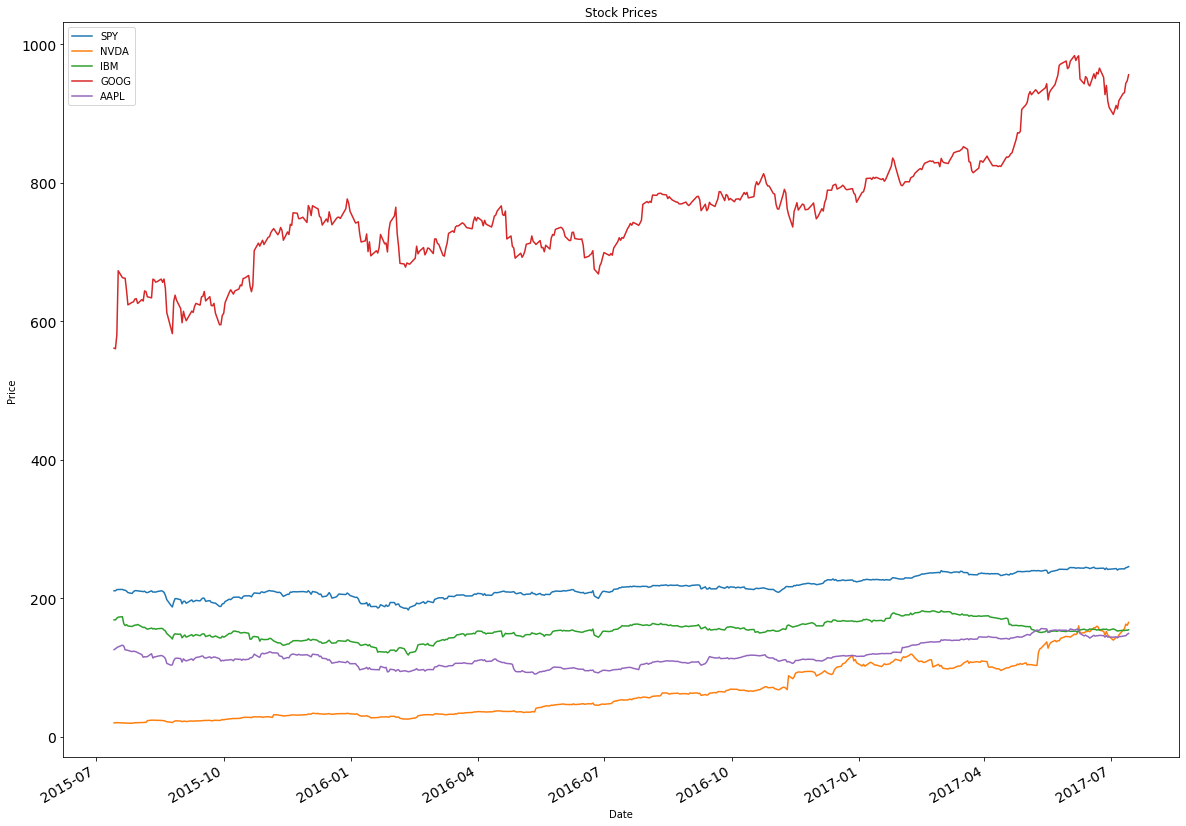

In [9]:
plot_data(df_explore)

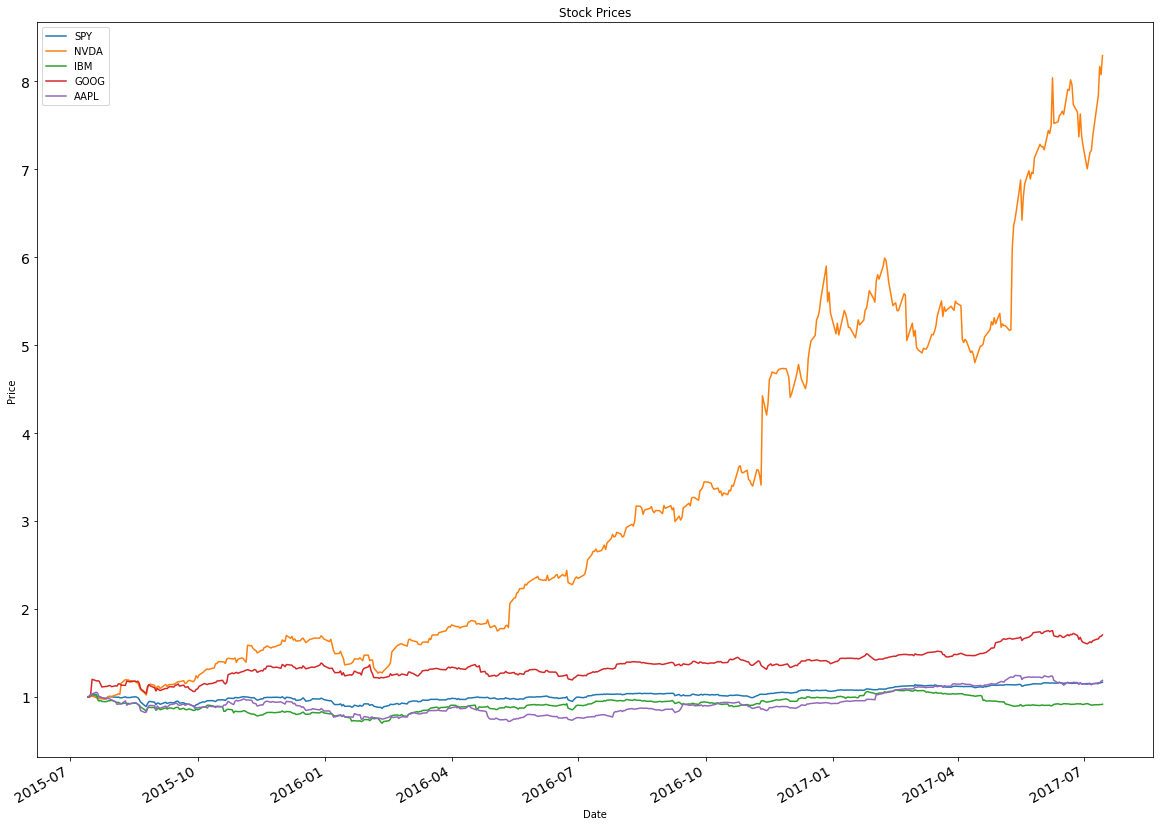

In [10]:
normalized_data = normalize_data(df_explore)
plot_data(normalized_data)

Based on the printed graphs we can see that NVDA is signigicanly more volitile over the two year period than the benchmark S&P 500 and the other stocks evaluated

## Global Stats
---

Global stats of the stocks we are interested in


In [11]:
print_stats(normalized_data)

Global Mean:
SPY     1.021891
NVDA    3.246513
IBM     0.910470
GOOG    1.357082
AAPL    0.927906
dtype: float64

Global Median:
SPY     1.008686
NVDA    2.654098
IBM     0.909703
GOOG    1.347870
AAPL    0.899809
dtype: float64

Global Std:
SPY     0.072933
NVDA    1.982375
IBM     0.078761
GOOG    0.154974
AAPL    0.134810
dtype: float64


## Rolling Stats
---
Visualization of the rolling stats

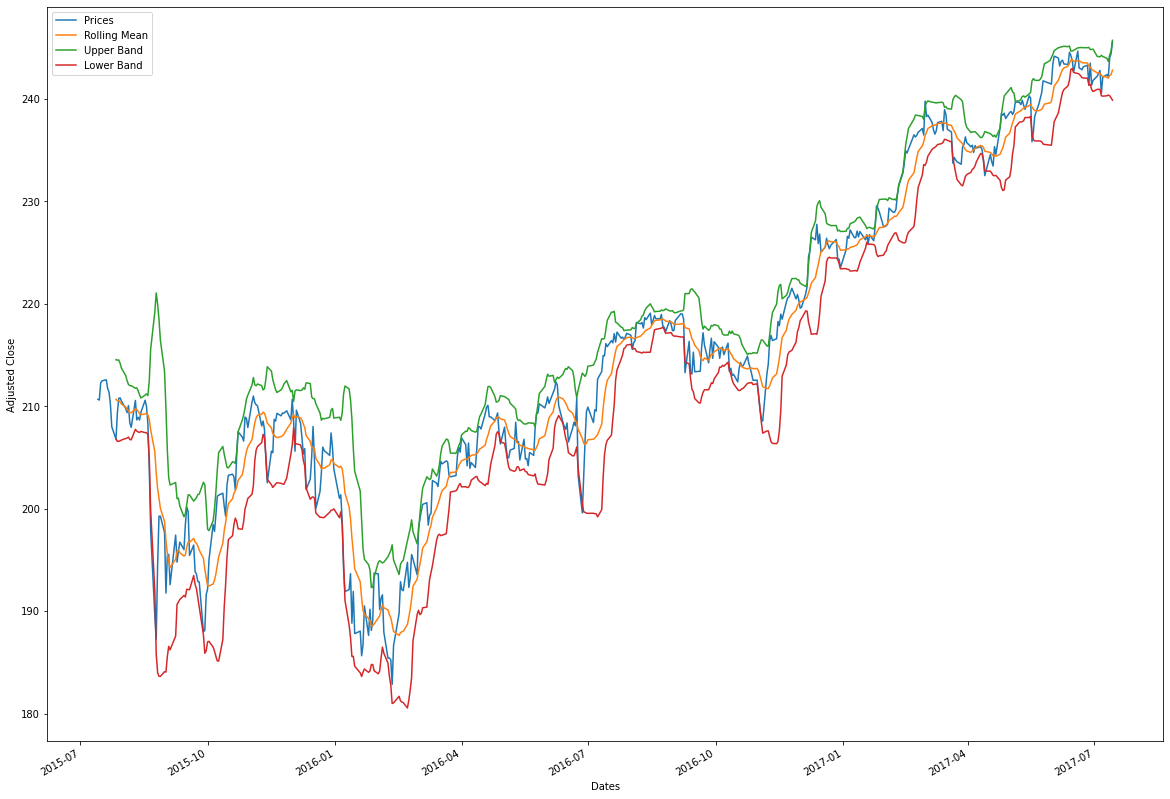

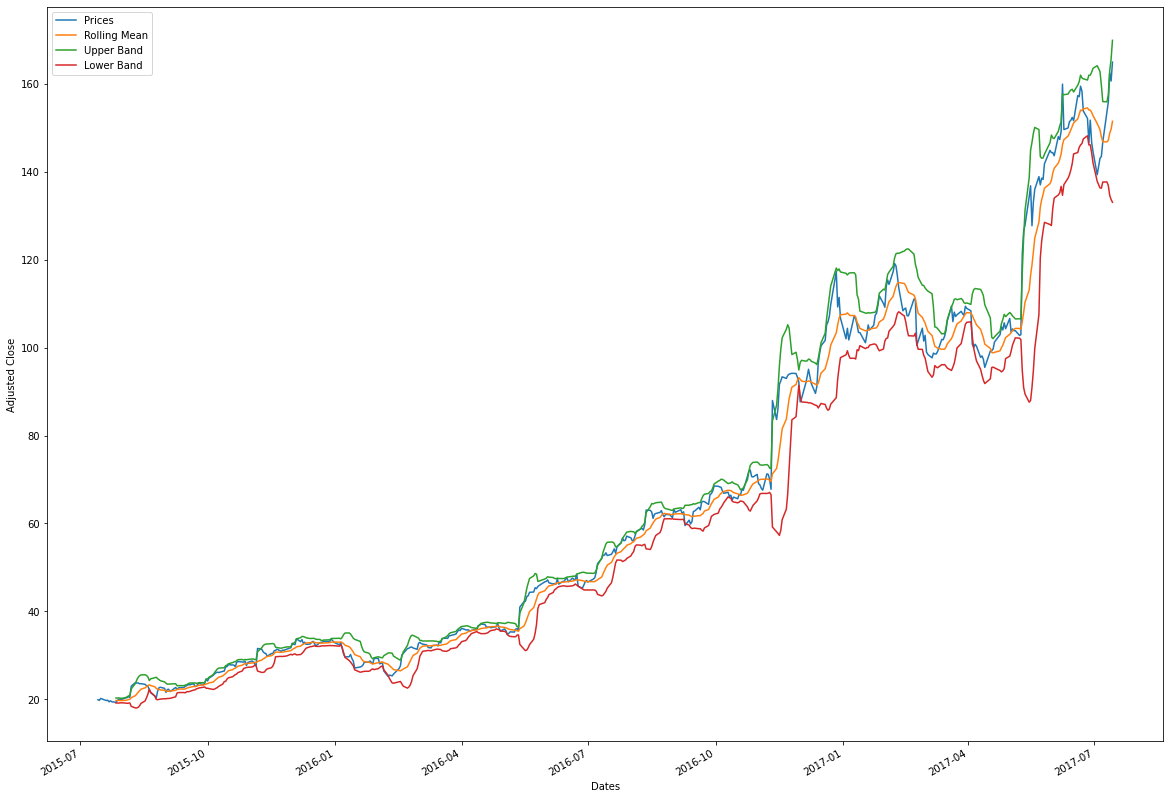

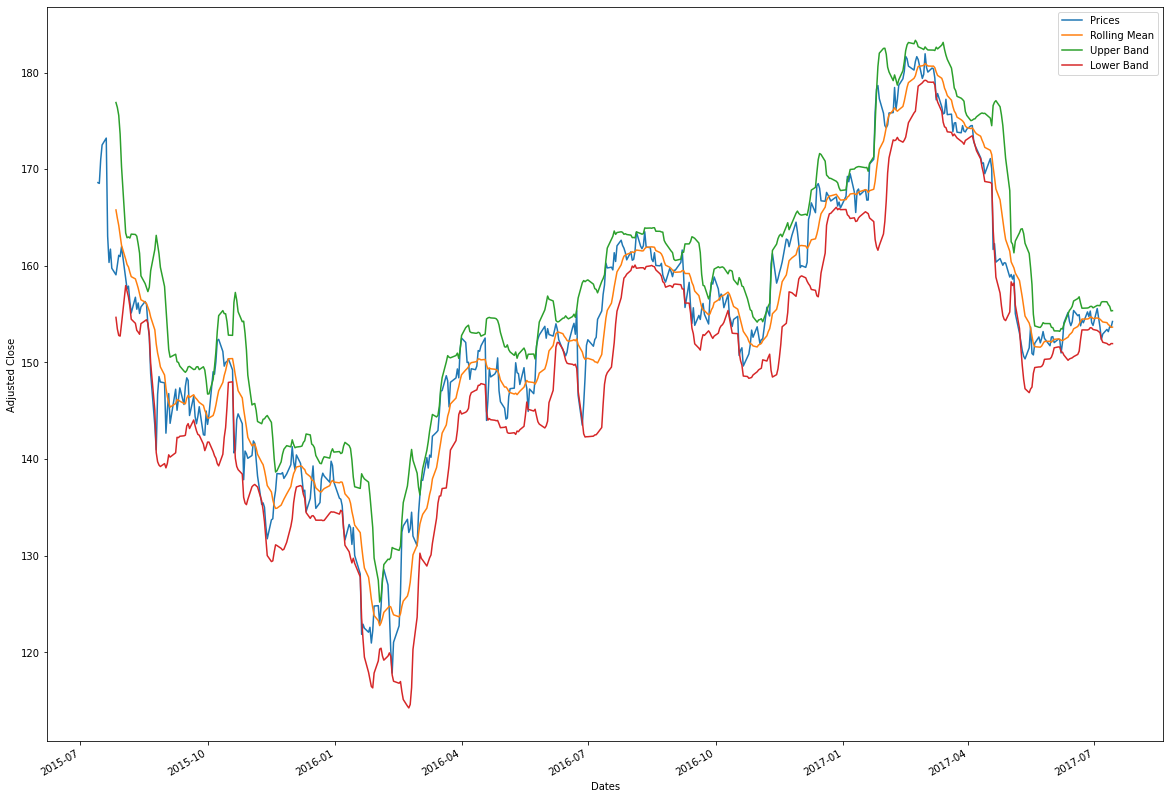

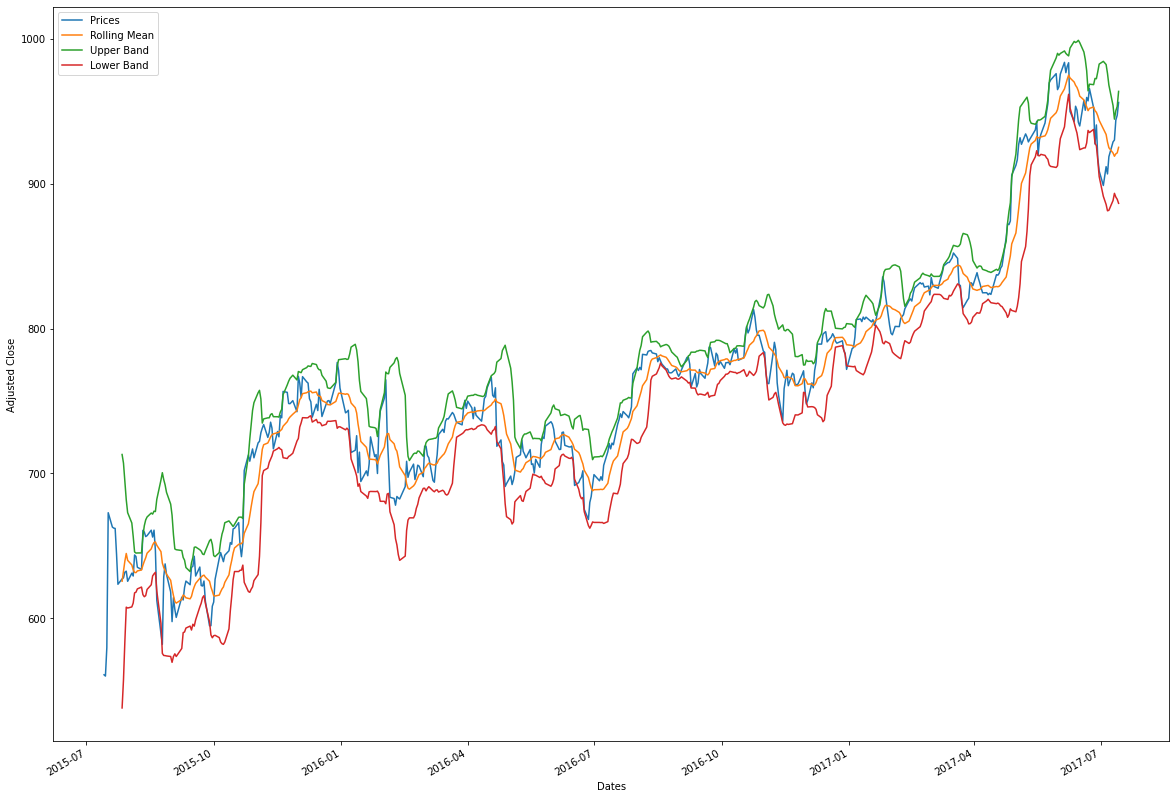

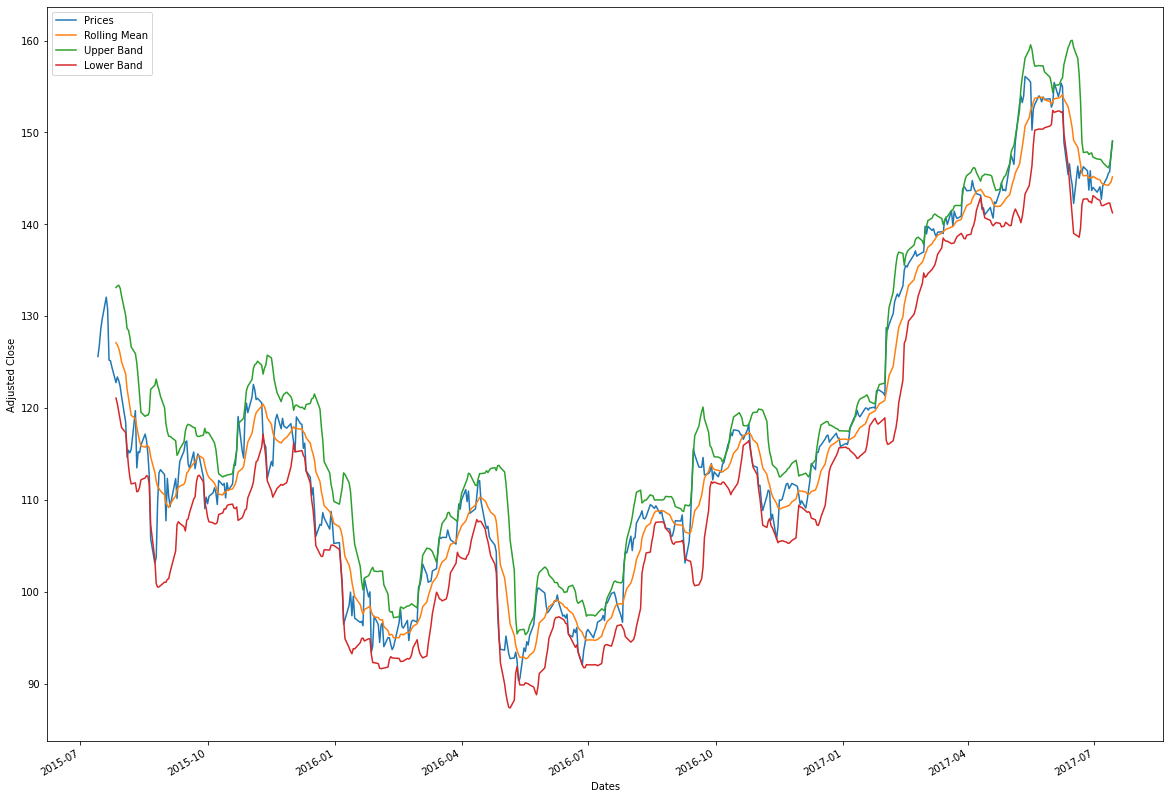

In [12]:
for symbol in tickers:
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)
    lower_band, upper_band = get_bollinger_bands(rolling_mean, rolling_std)
    print_bollinger_bands(df_explore[symbol], rolling_mean, lower_band, upper_band, symbol)

## Daily Returns
---
Visualization of daily returns

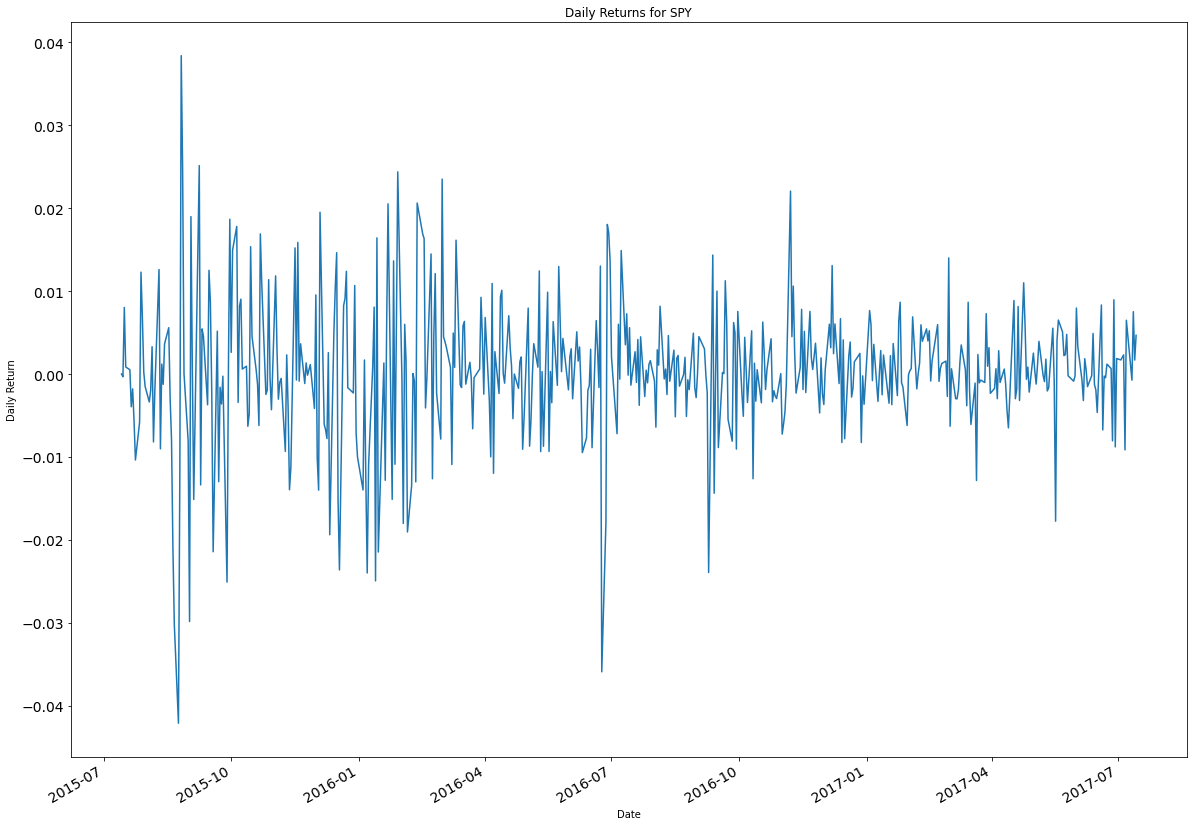

Max/Min Daily Returns for SPY
Max: 0.038393778215543906
Min: -0.04210686910876138





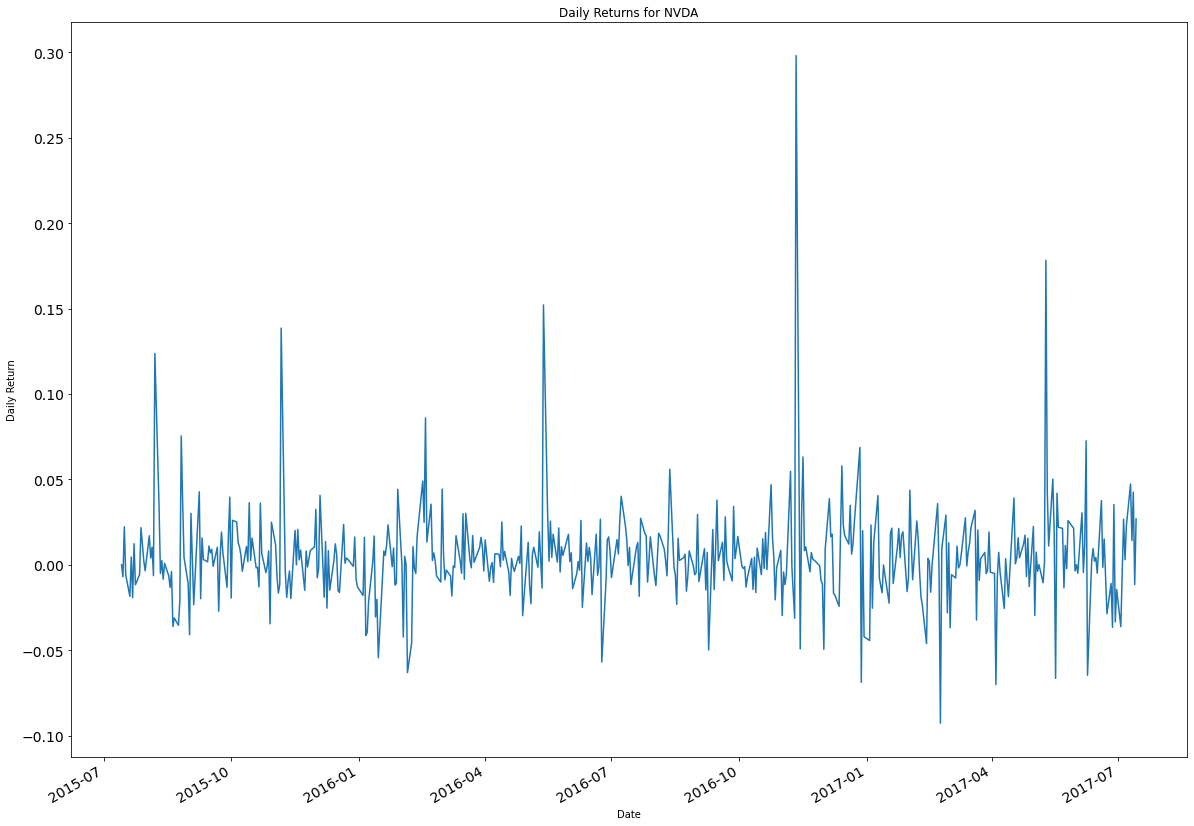

Max/Min Daily Returns for NVDA
Max: 0.2980670635118958
Min: -0.09272303913465074





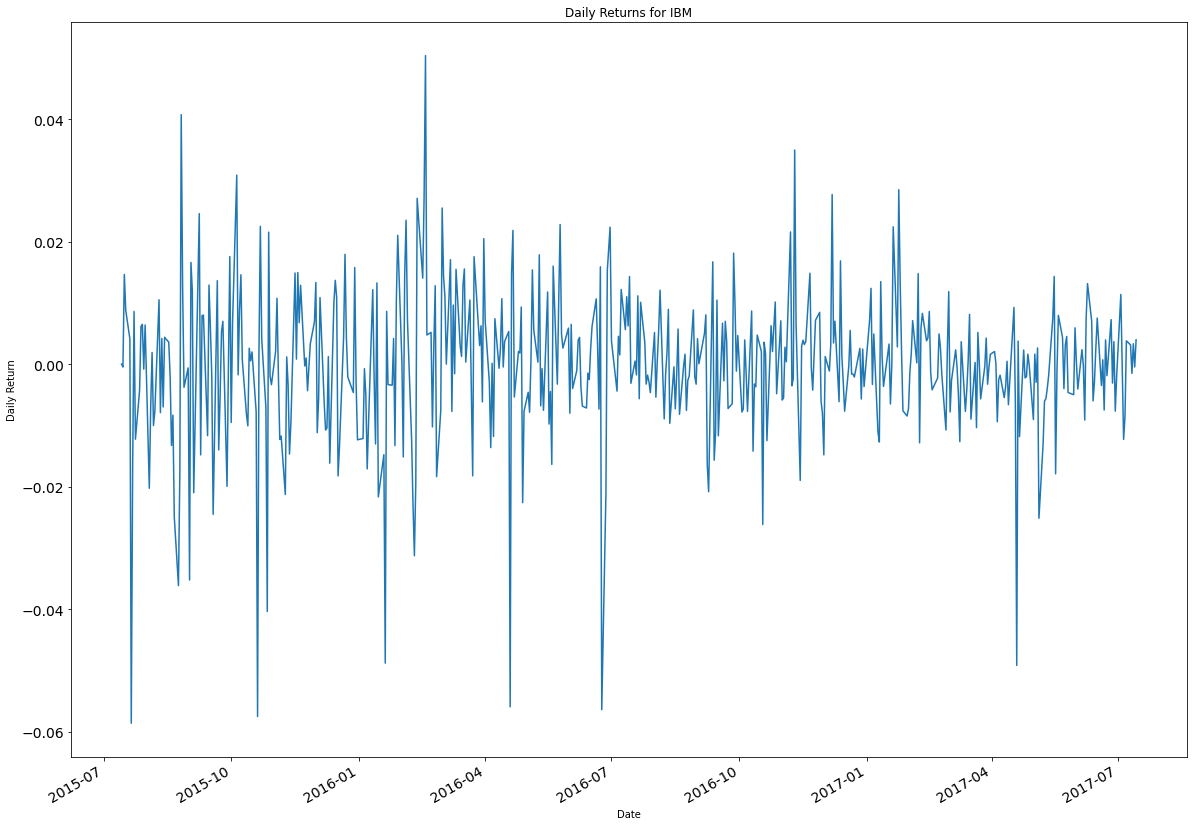

Max/Min Daily Returns for IBM
Max: 0.050356852503677274
Min: -0.058595970103937356





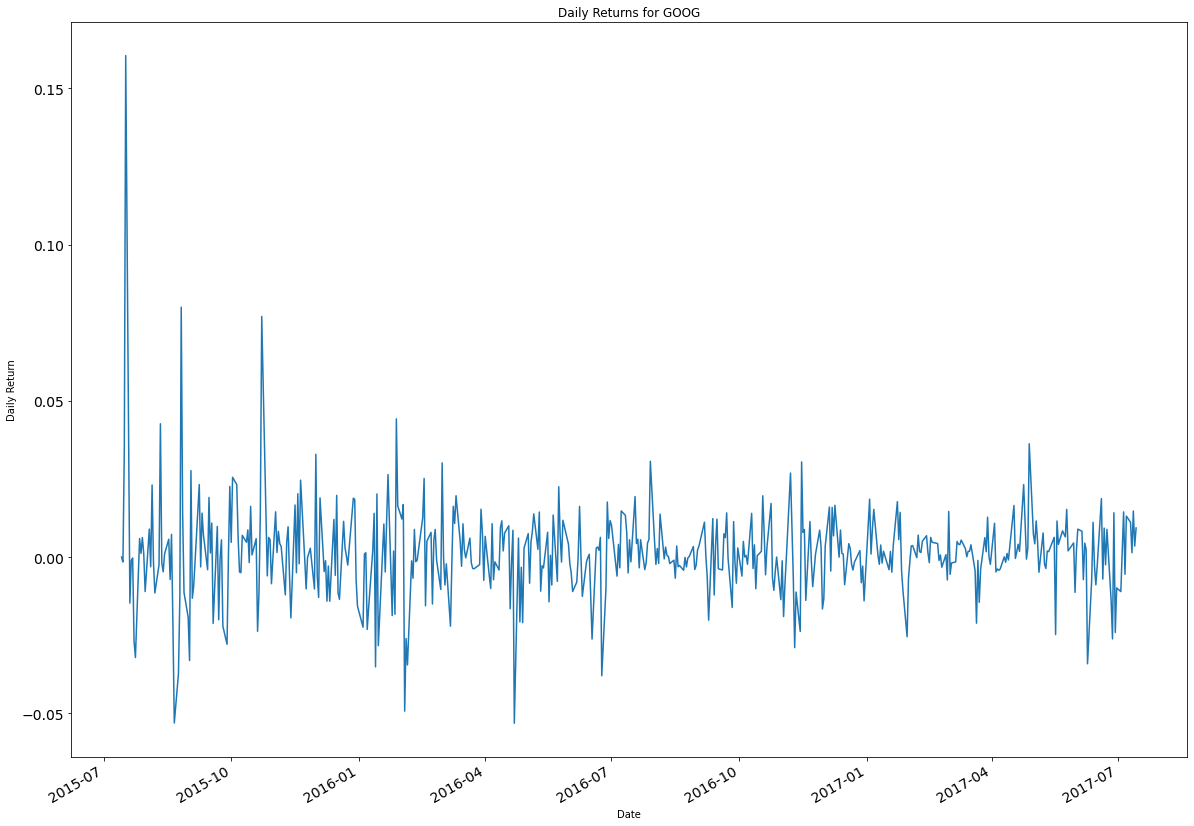

Max/Min Daily Returns for GOOG
Max: 0.16052430948104401
Min: -0.05317858919609186





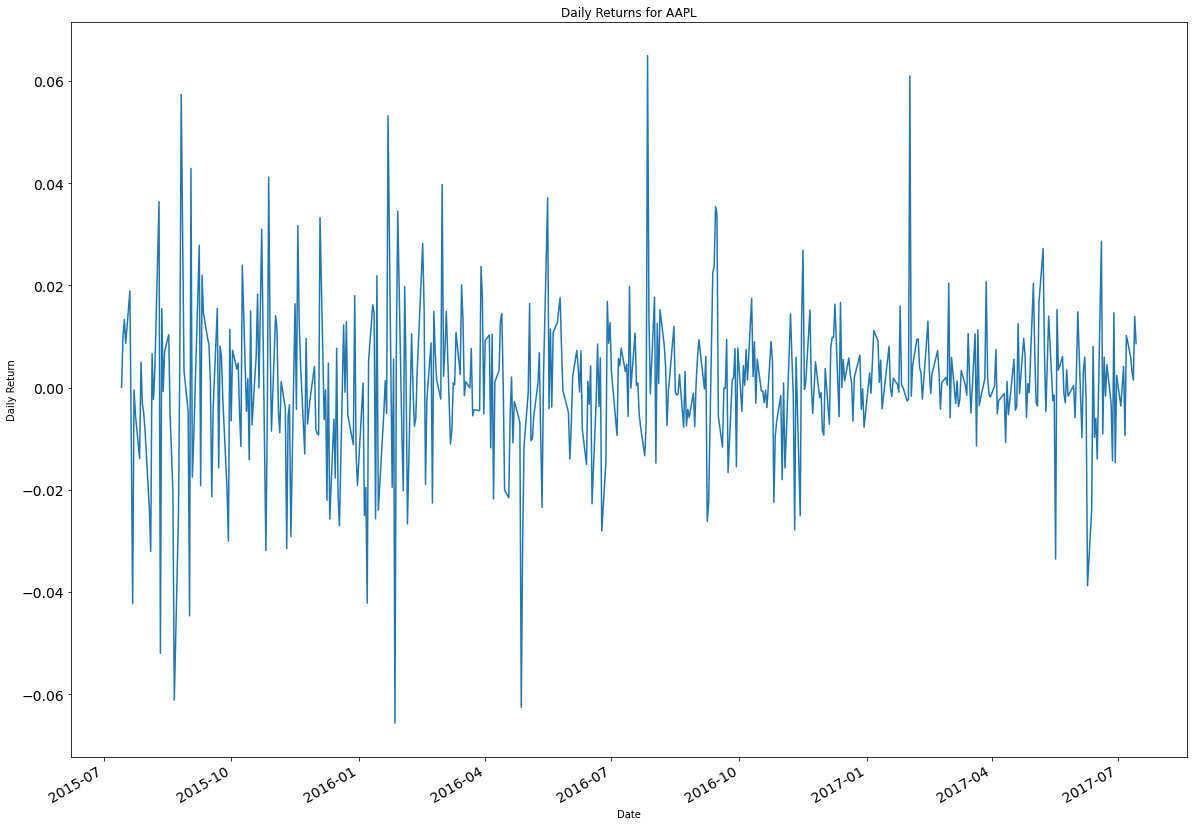

Max/Min Daily Returns for AAPL
Max: 0.0649632681279253
Min: -0.06570657197132868





In [14]:
daily_returns  = get_daily_returns(df_explore)
for symbol in tickers:
    plot_data(daily_returns[symbol], title='Daily Returns for ' + symbol, xlabel='Date', ylabel='Daily Return')

    print ('Max/Min Daily Returns for ' + symbol)
    print ('Max:', daily_returns[symbol].max())
    print ('Min:', daily_returns[symbol].min())
    print ('\n\n')

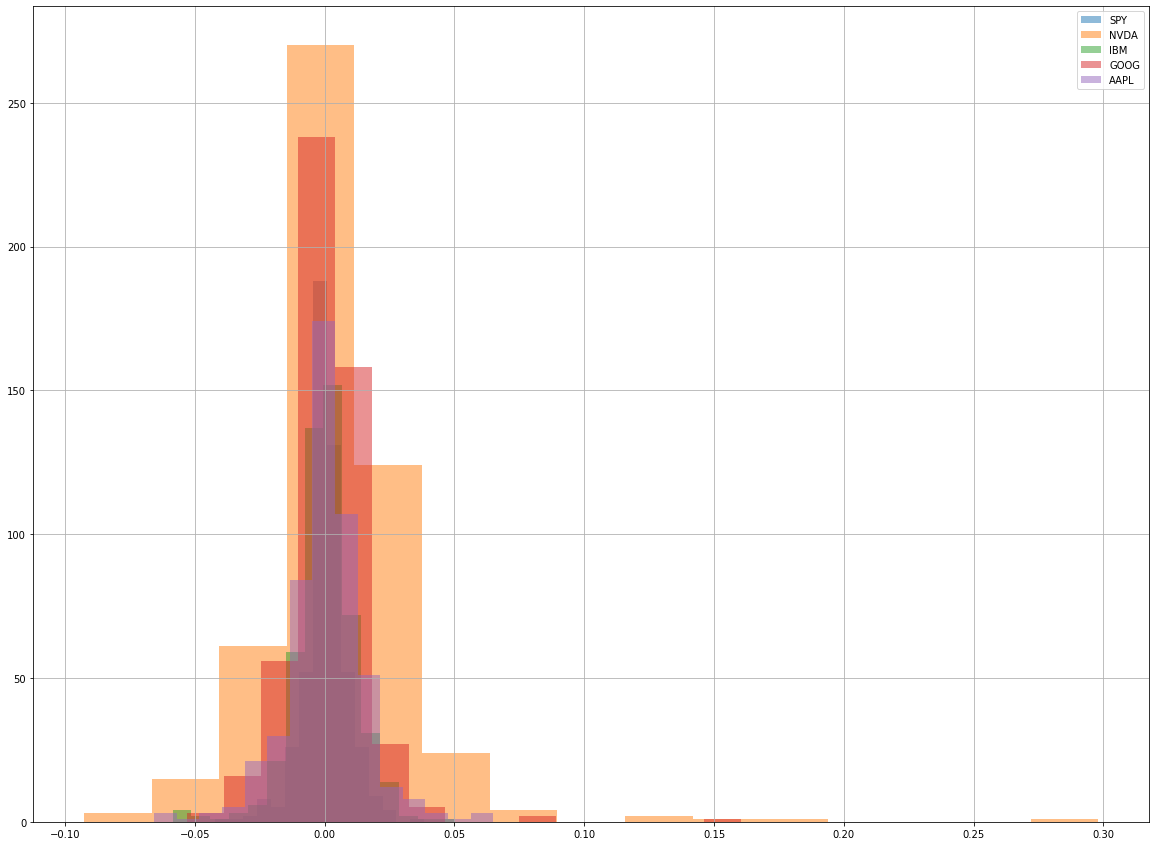

In [15]:
plot_hist_multi(daily_returns, bins=15)

## Momentum
---

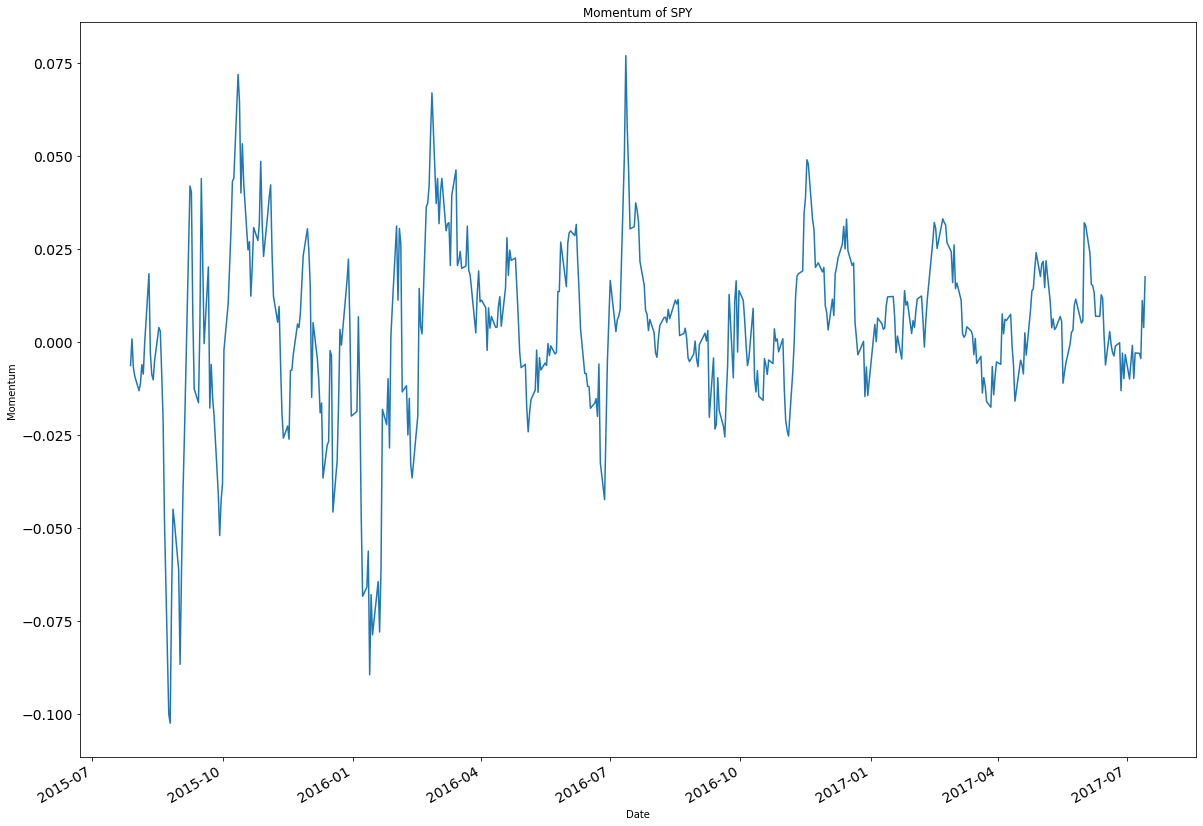

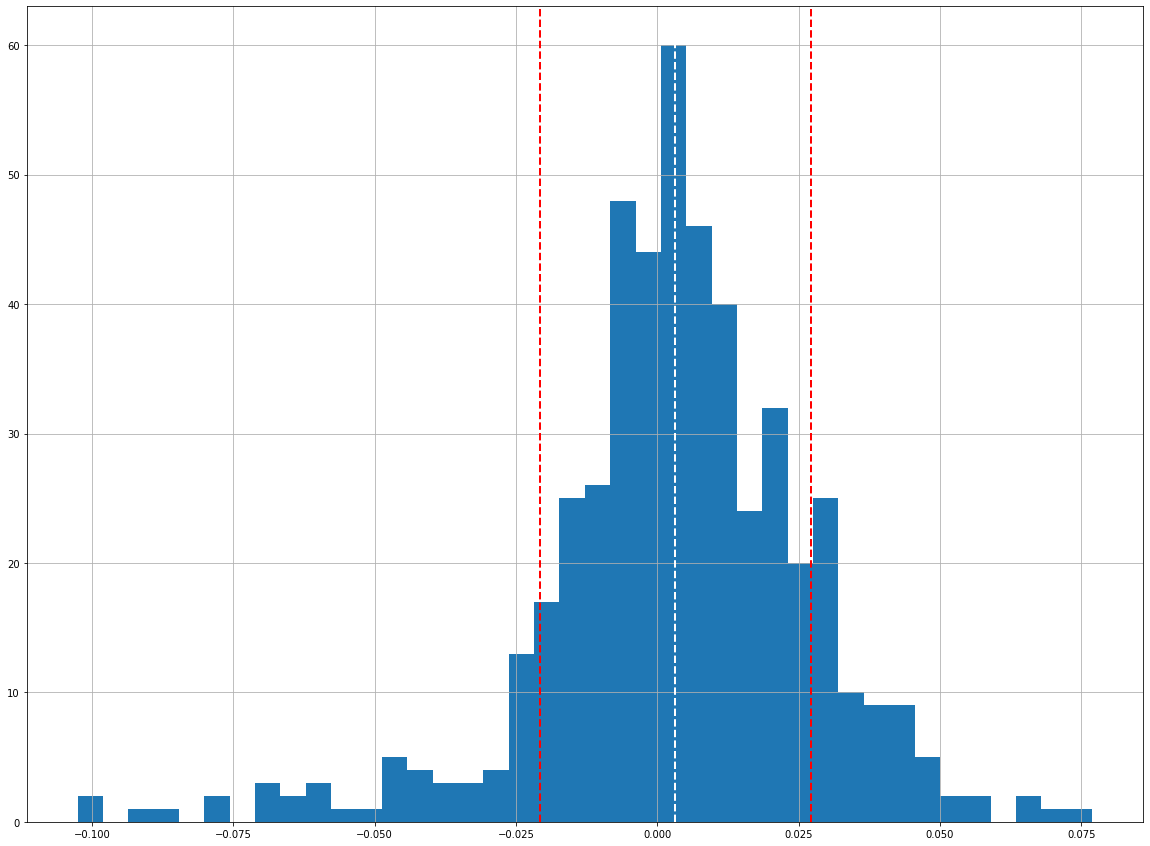

Max/Min Momentum for SPY
Max: 0.0769037602133138
Min: -0.10255424452536777





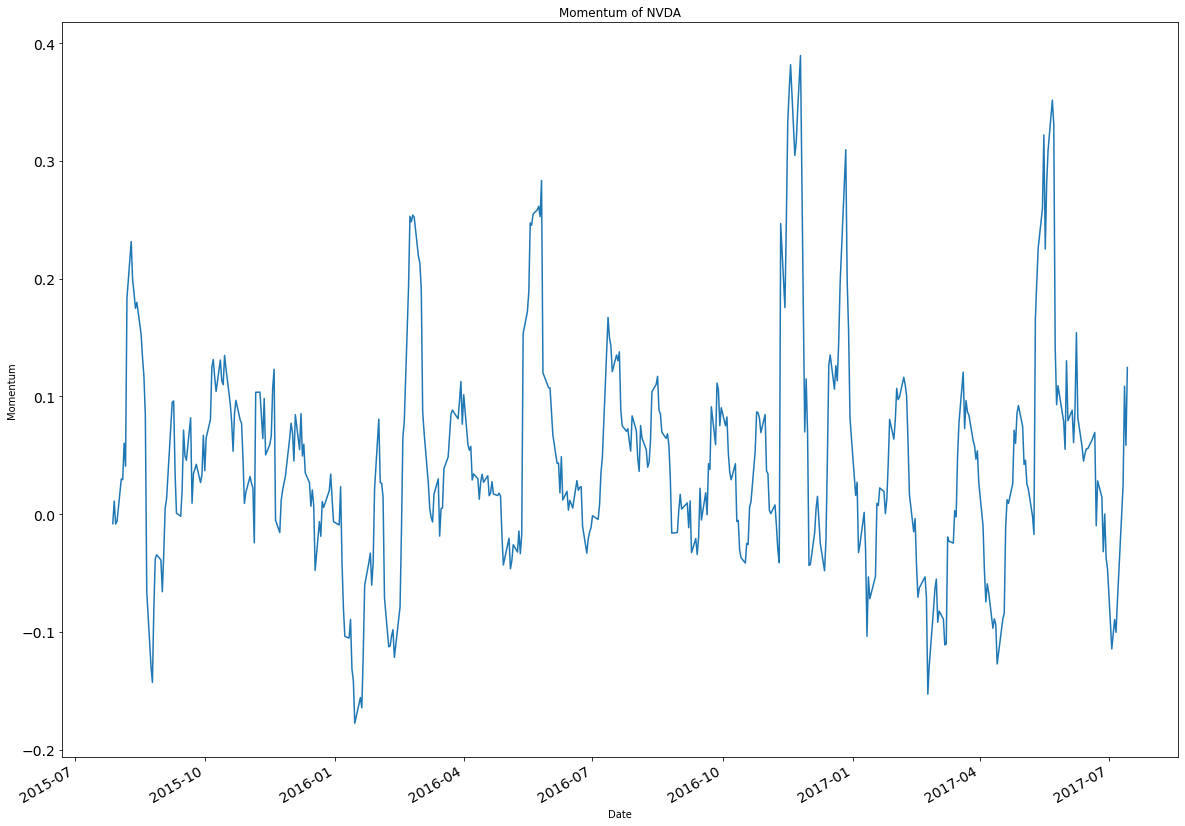

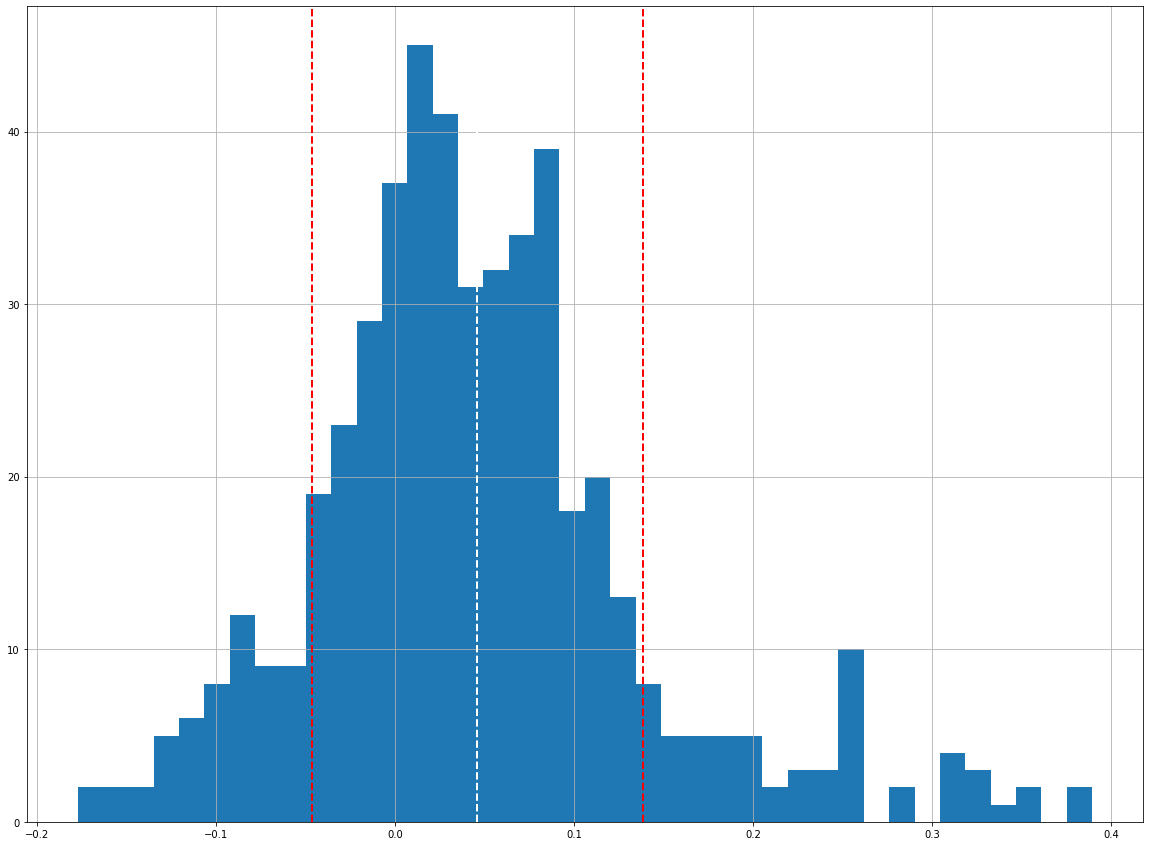

Max/Min Momentum for NVDA
Max: 0.38940546212507576
Min: -0.17748780878300385





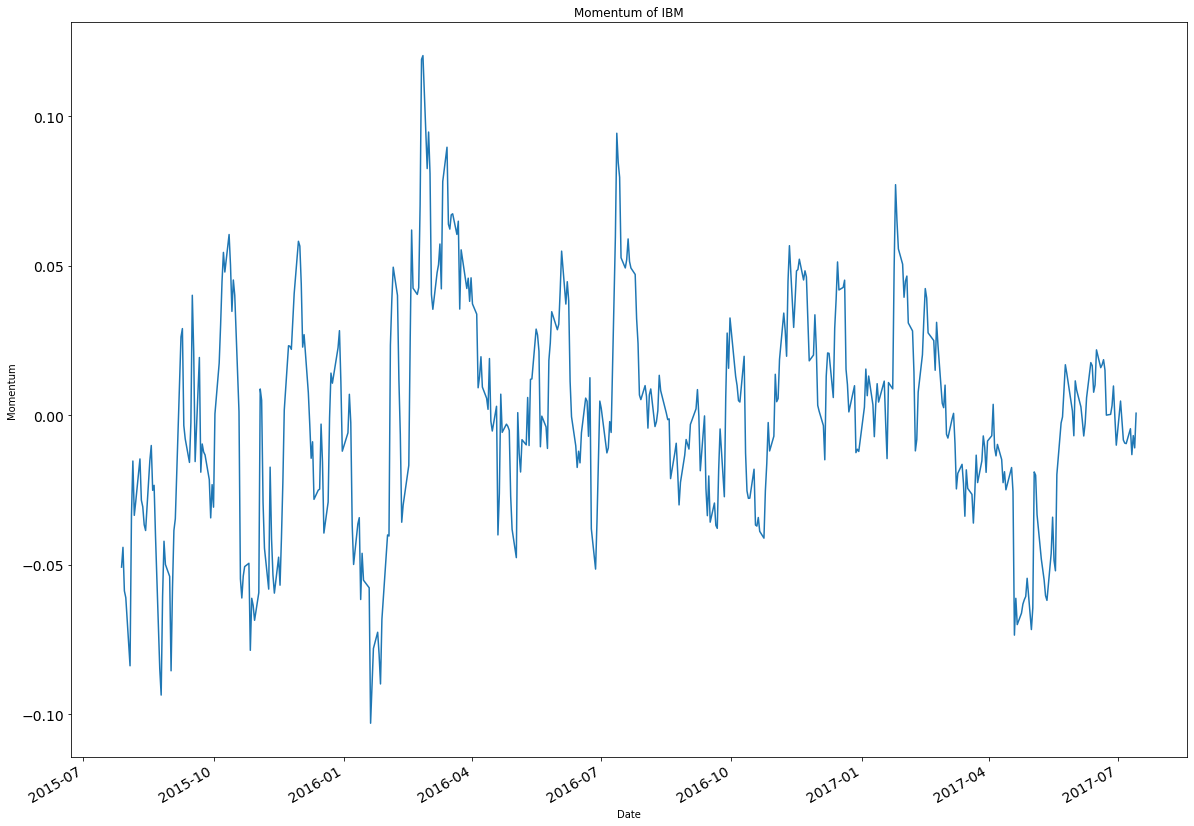

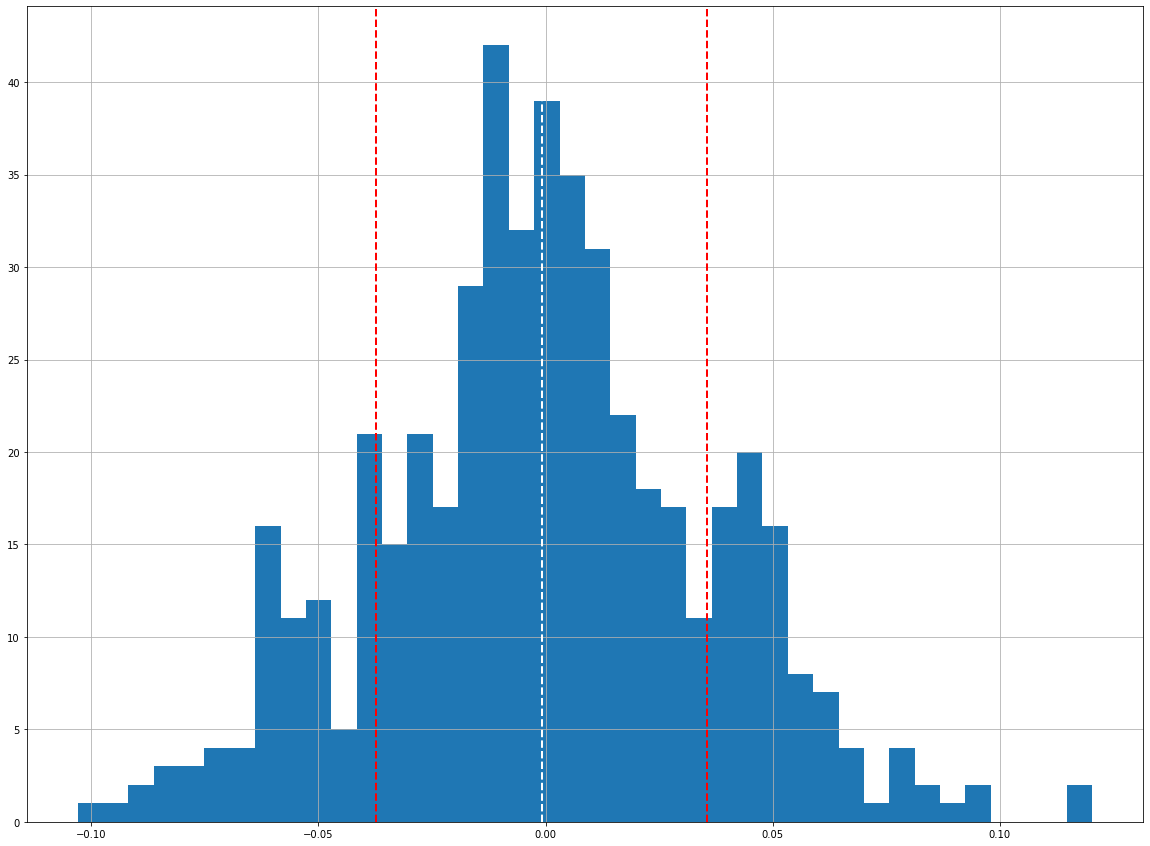

Max/Min Momentum for IBM
Max: 0.120322454311794
Min: -0.10298126155401133





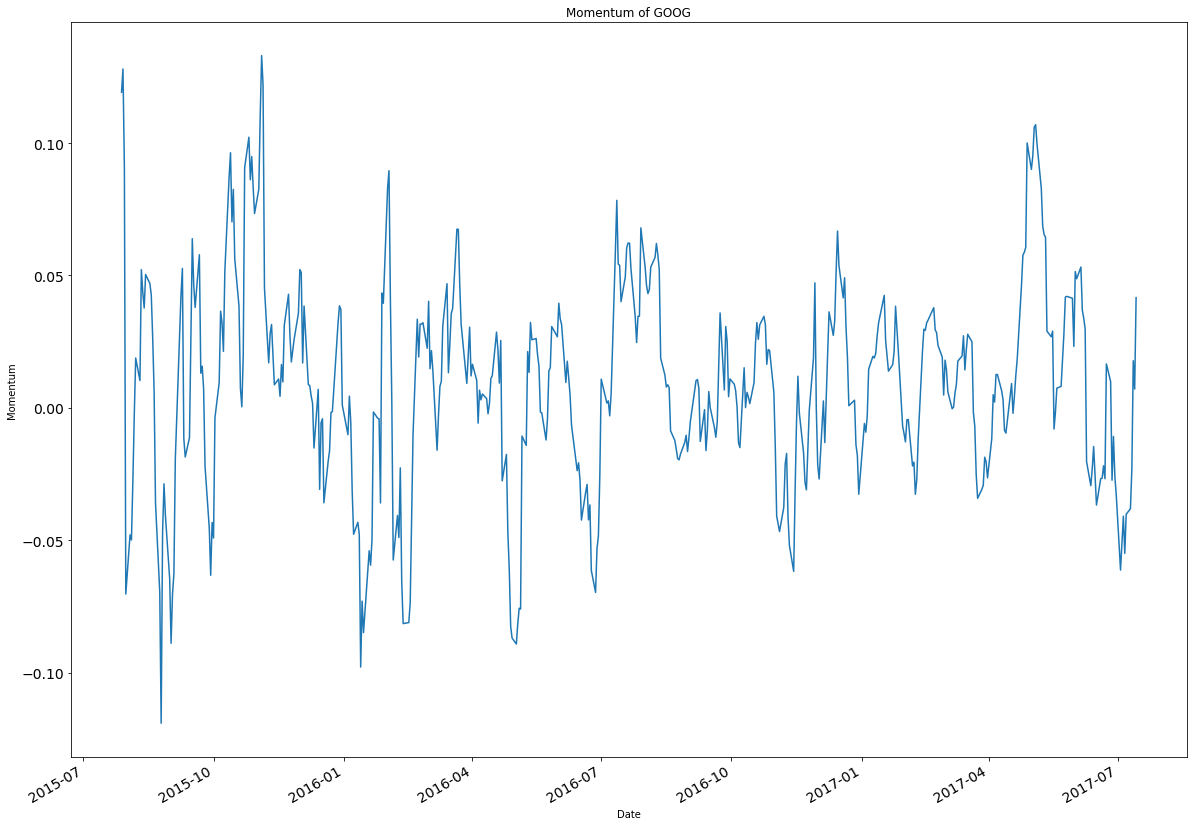

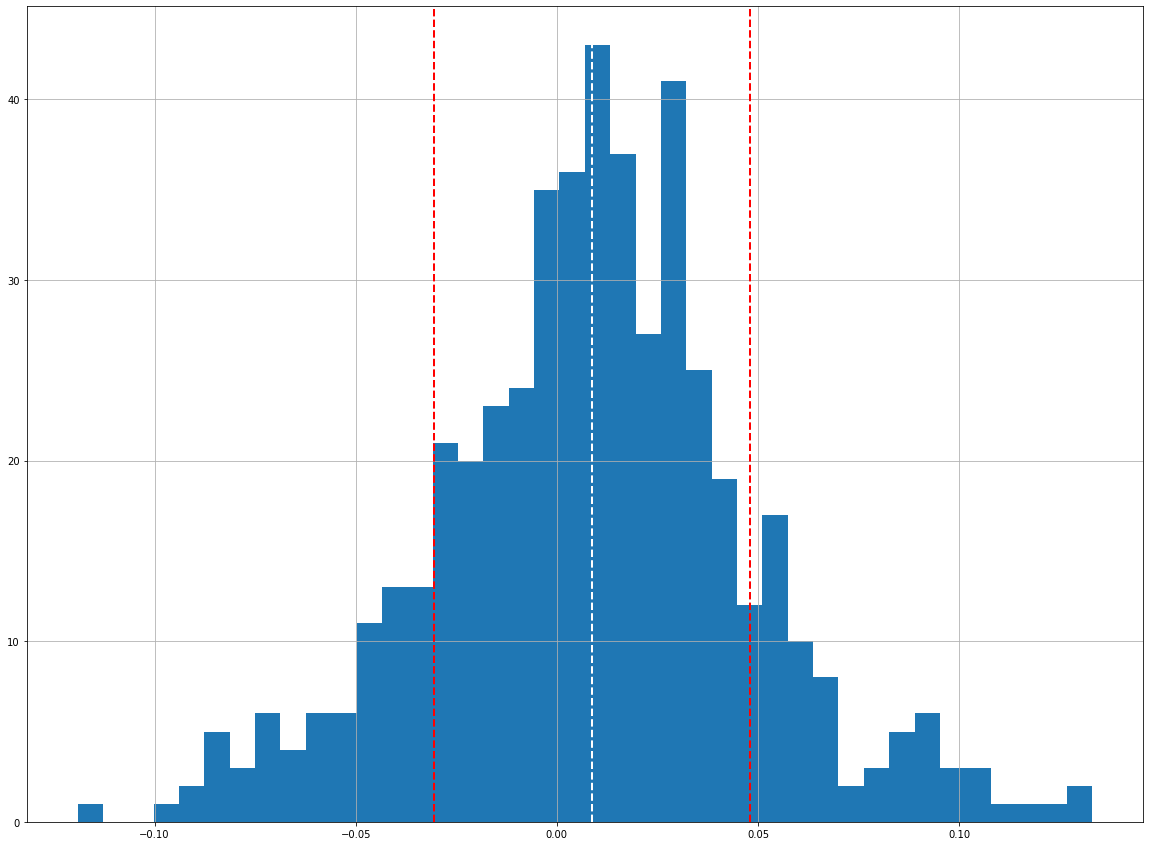

Max/Min Momentum for GOOG
Max: 0.1330511538814636
Min: -0.11913197667177067





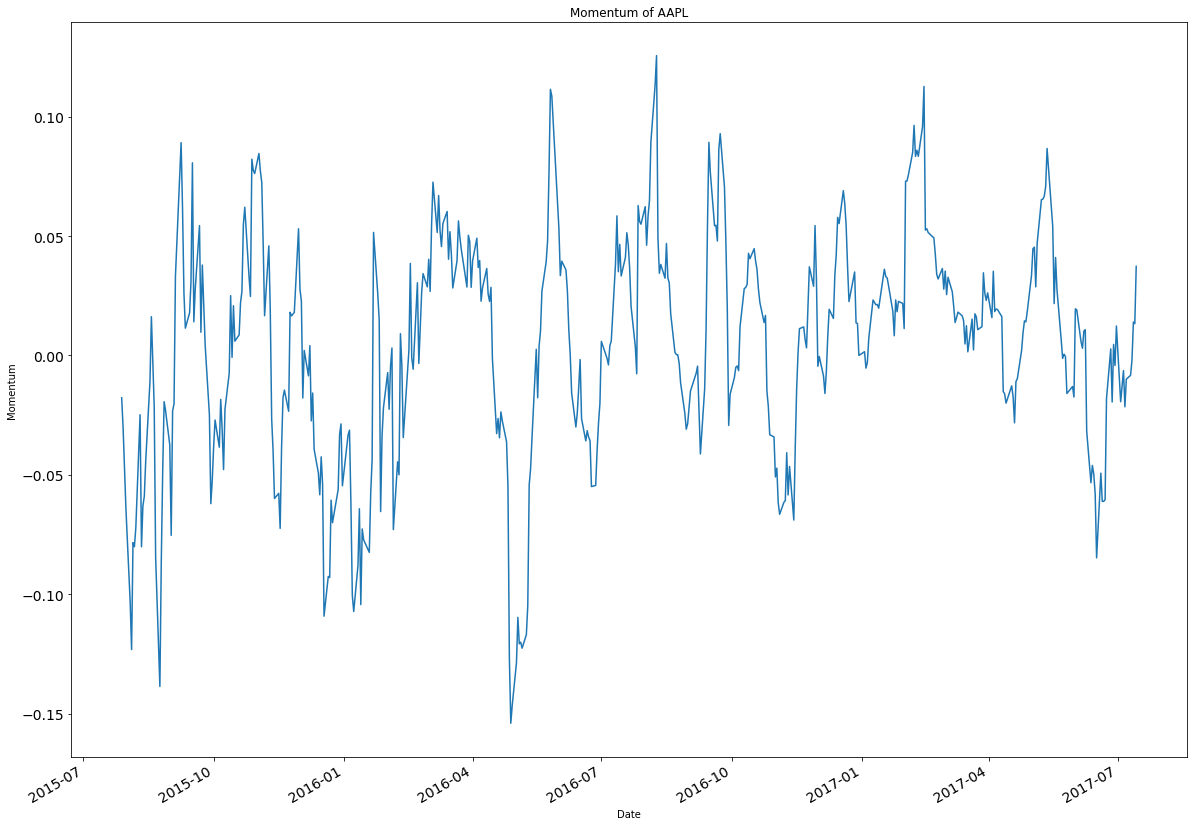

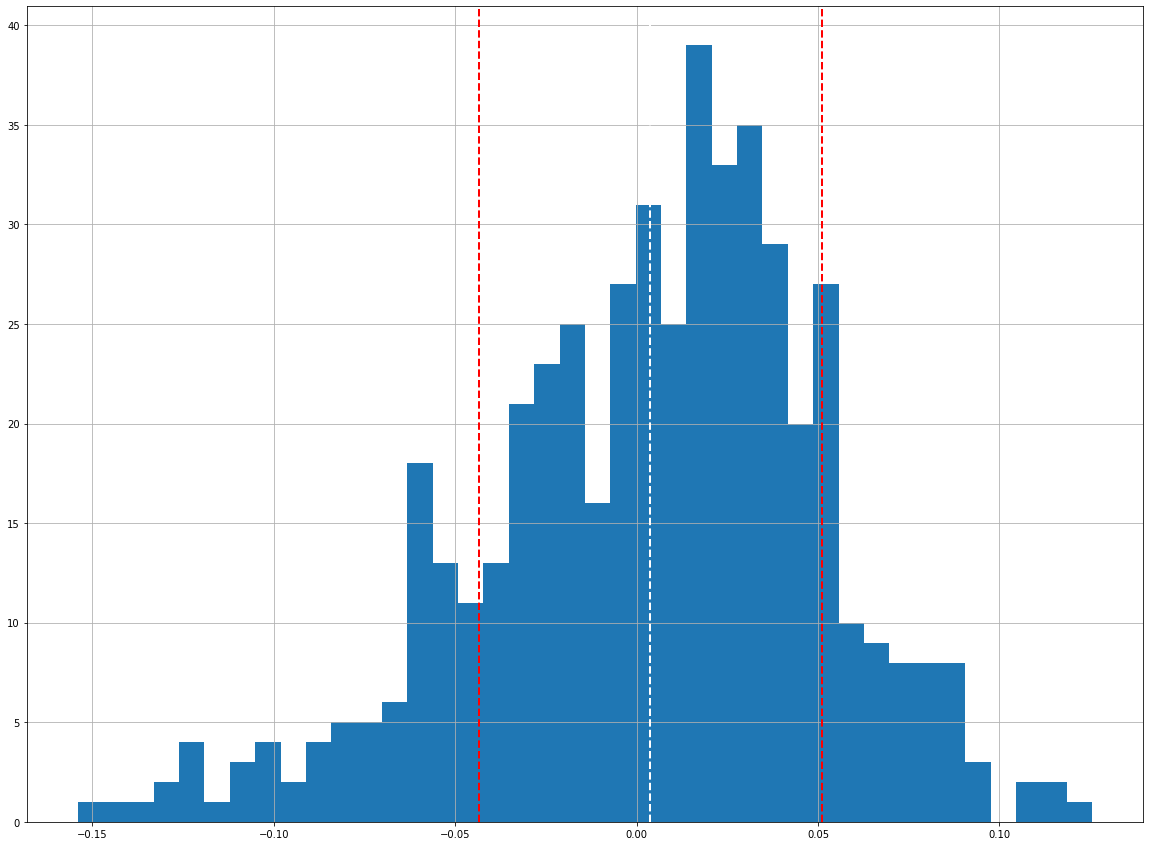

Max/Min Momentum for AAPL
Max: 0.12558187908517393
Min: -0.15405884306973838





In [16]:
for symbol in tickers:
    momentum = get_momentum(df_explore[symbol], window=metrics_window)
    plot_data(momentum, title='Momentum of ' + symbol, xlabel='Date', ylabel='Momentum')
    plot_hist_with_stats(momentum, bins=40)

    print ('Max/Min Momentum for ' + symbol)
    print ('Max:', momentum.max())
    print ('Min:', momentum.min())
    print ('\n\n')

## Simple Moving Average Ratio
---

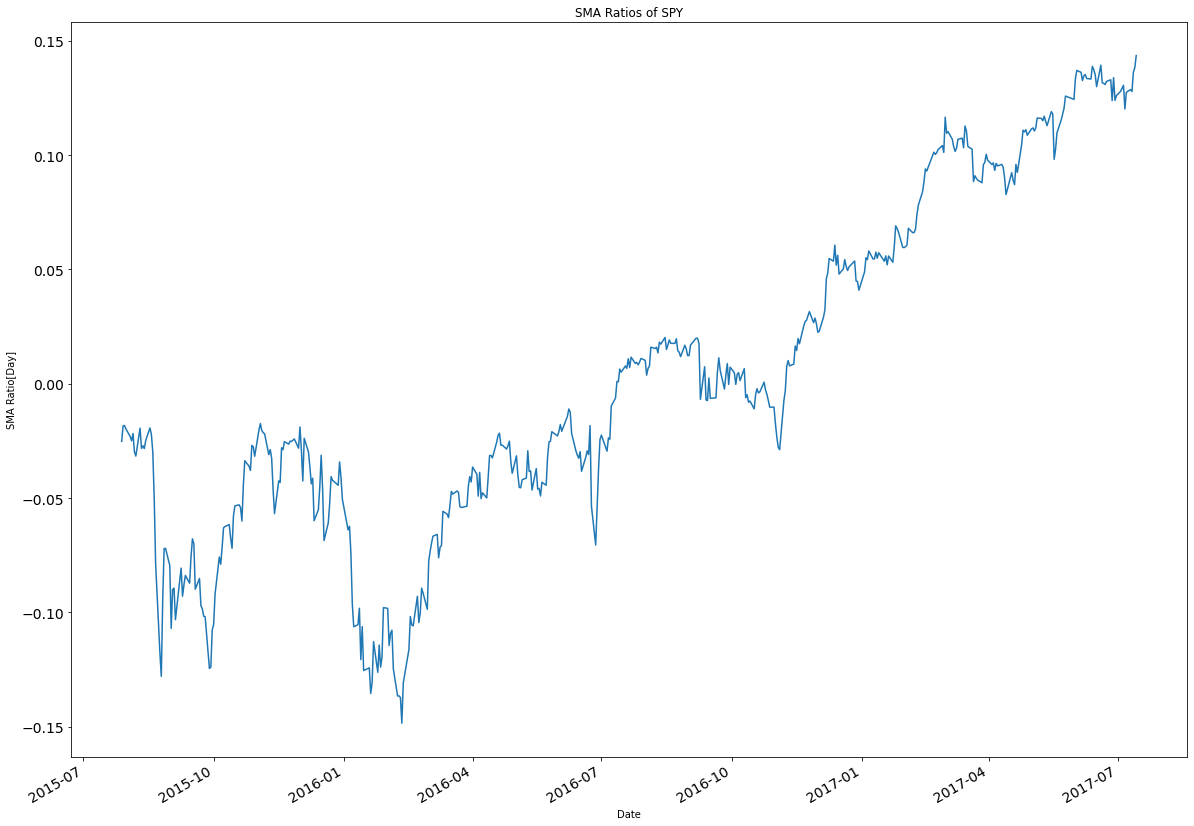

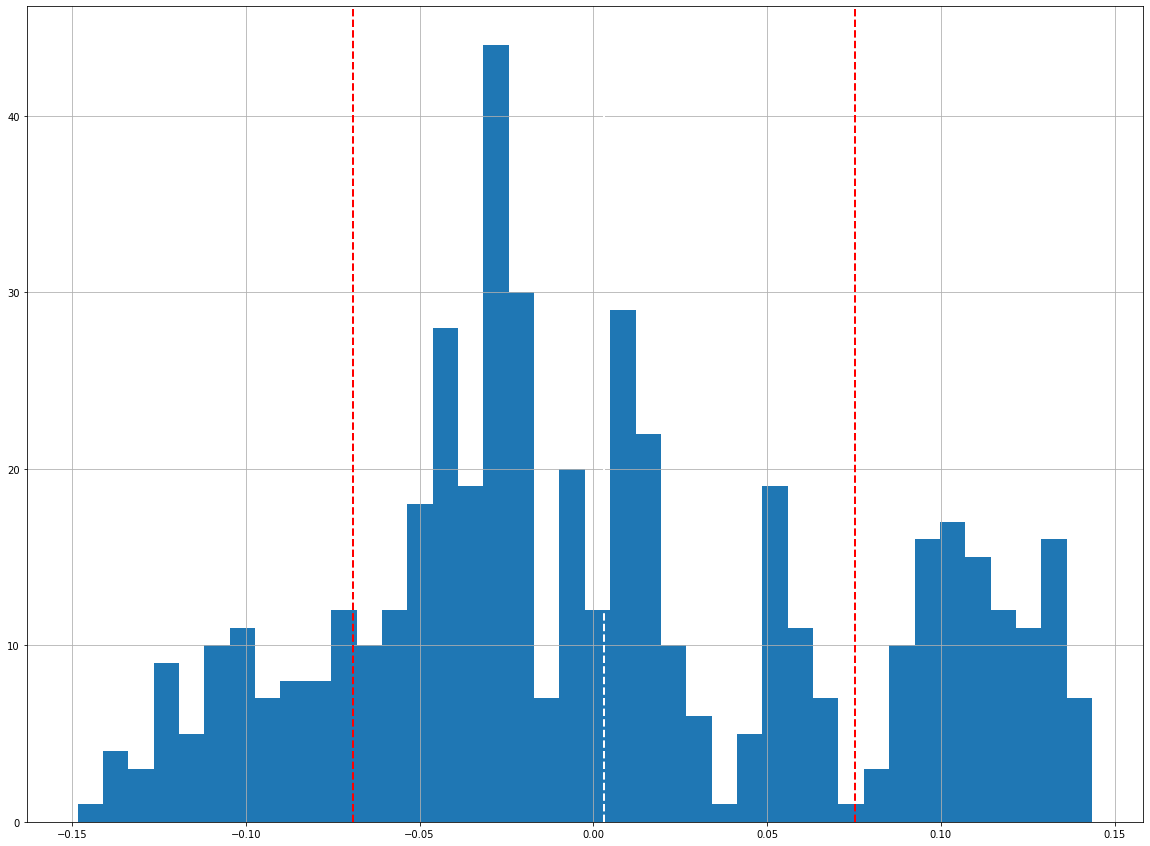

Max/Min SMA Ratio for SPY
Max:  0.14353623967219775
Min:  -0.14844828297321322


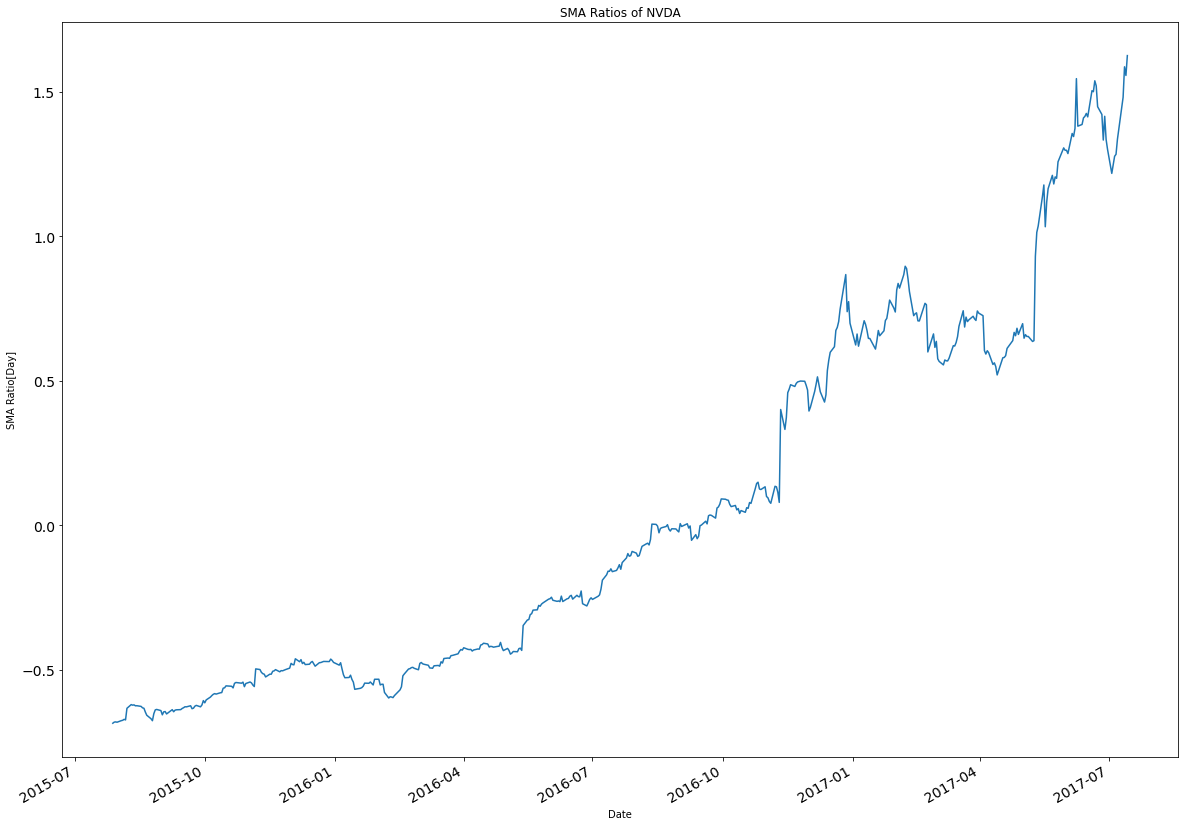

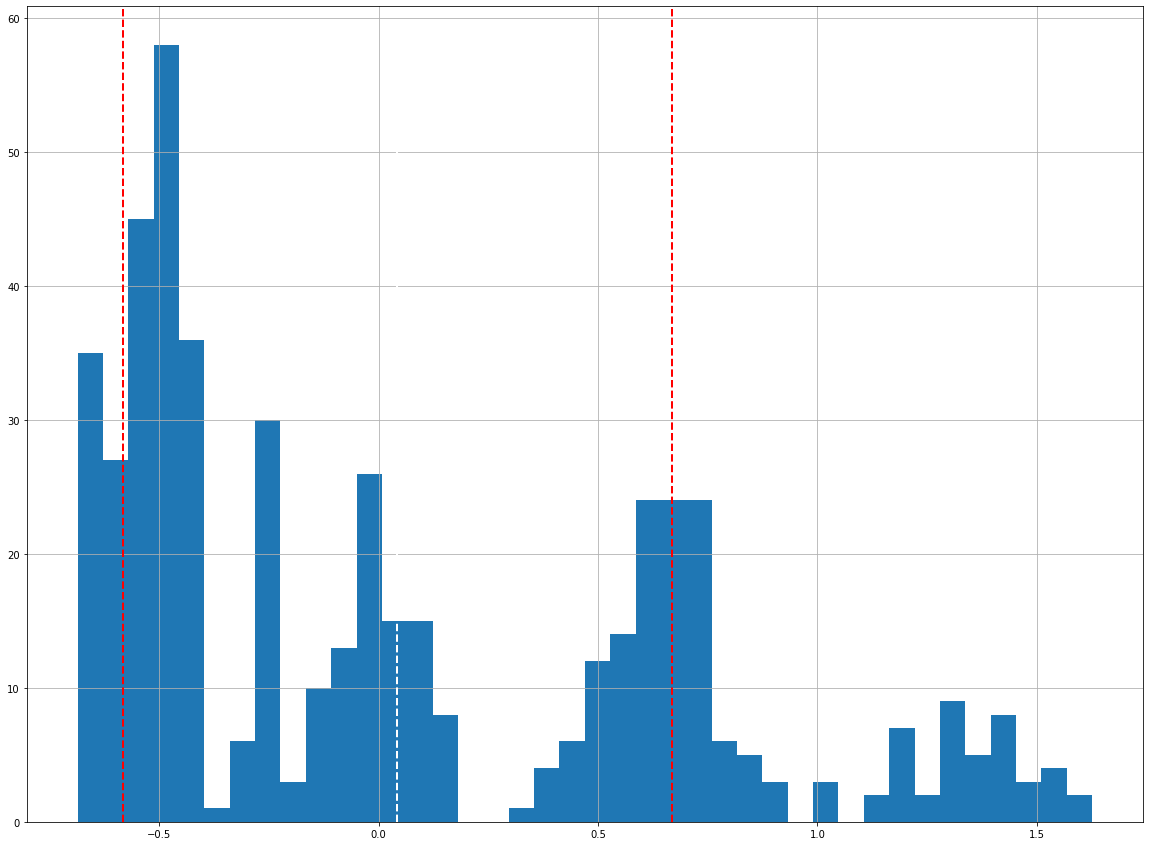

Max/Min SMA Ratio for NVDA
Max:  1.6257190066512042
Min:  -0.6859324829134233


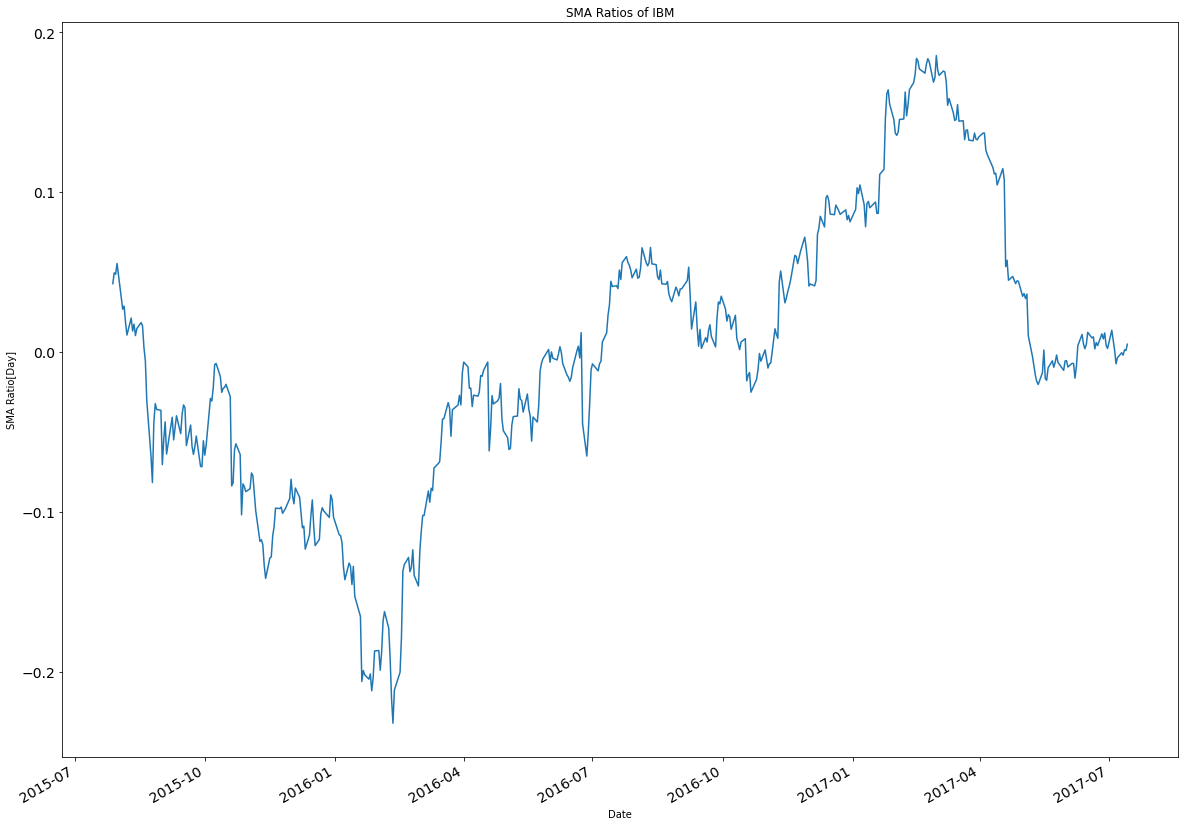

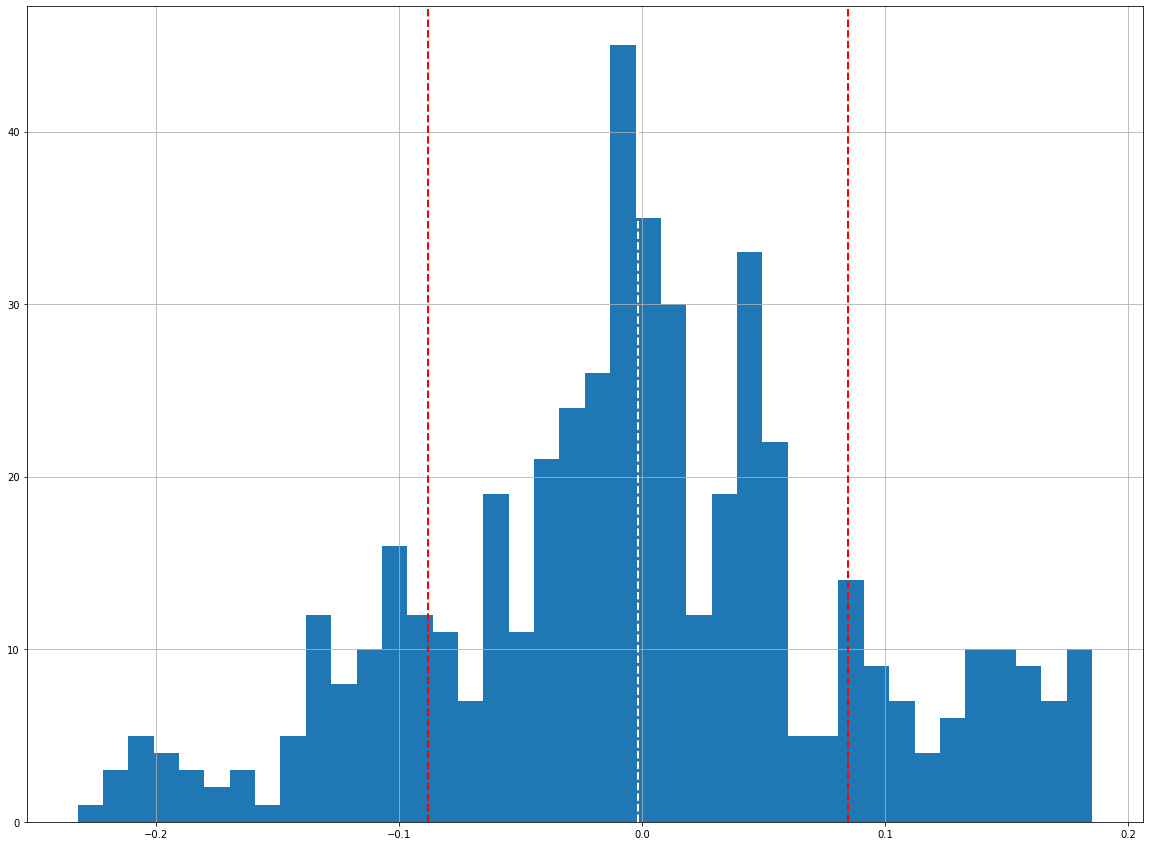

Max/Min SMA Ratio for IBM
Max:  0.185252953544079
Min:  -0.23230524590410517


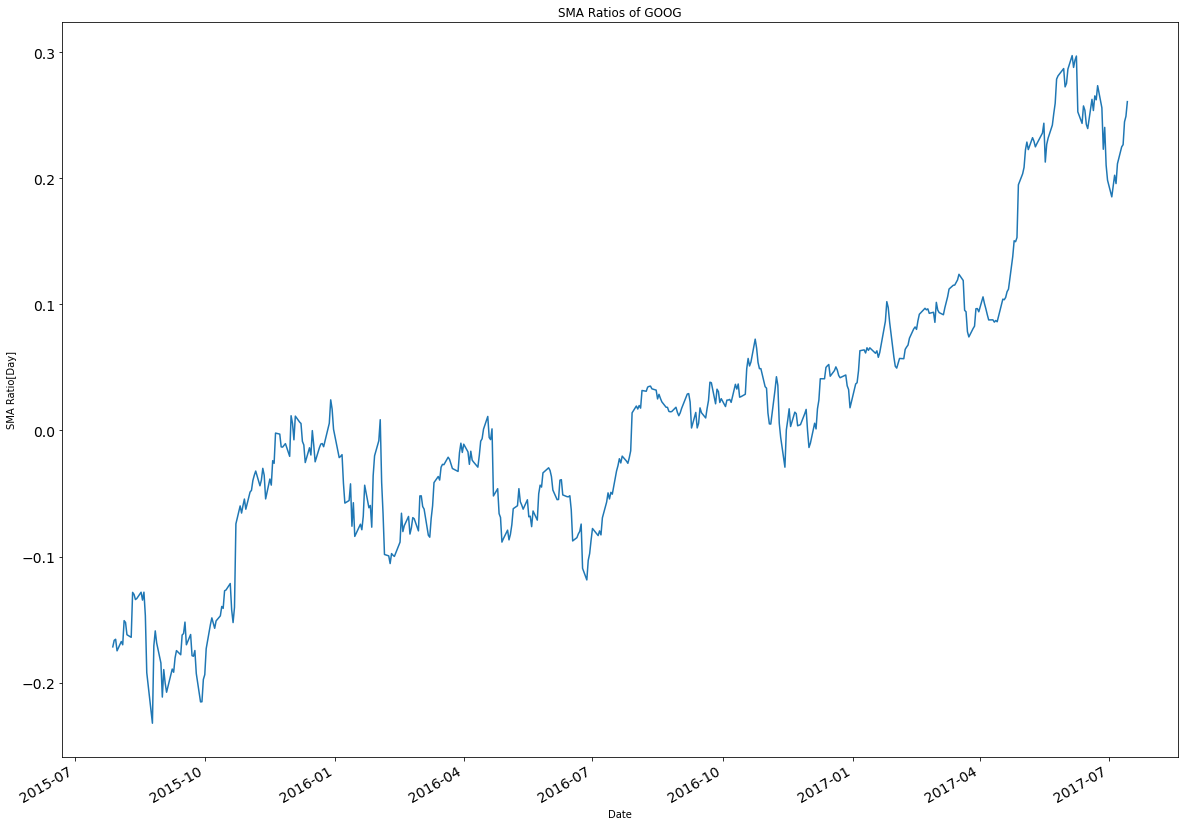

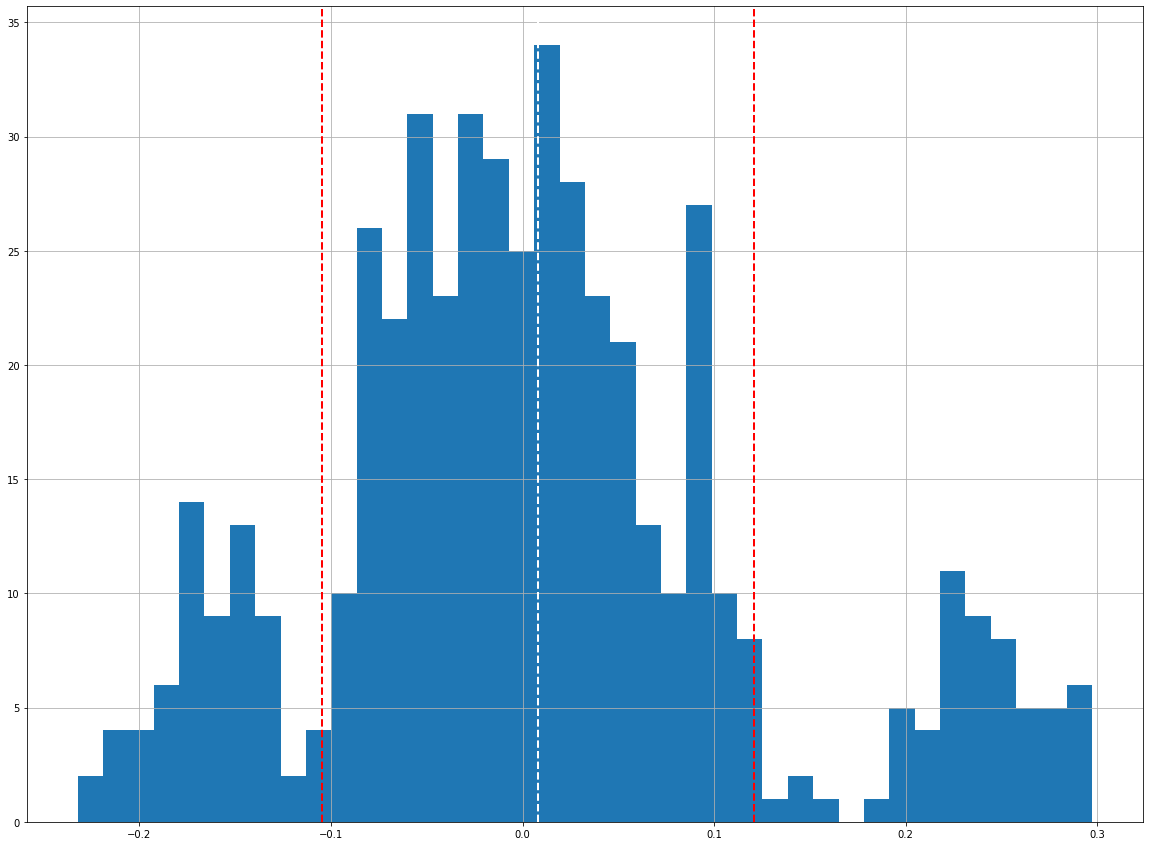

Max/Min SMA Ratio for GOOG
Max:  0.2974555433631414
Min:  -0.23227373093981474


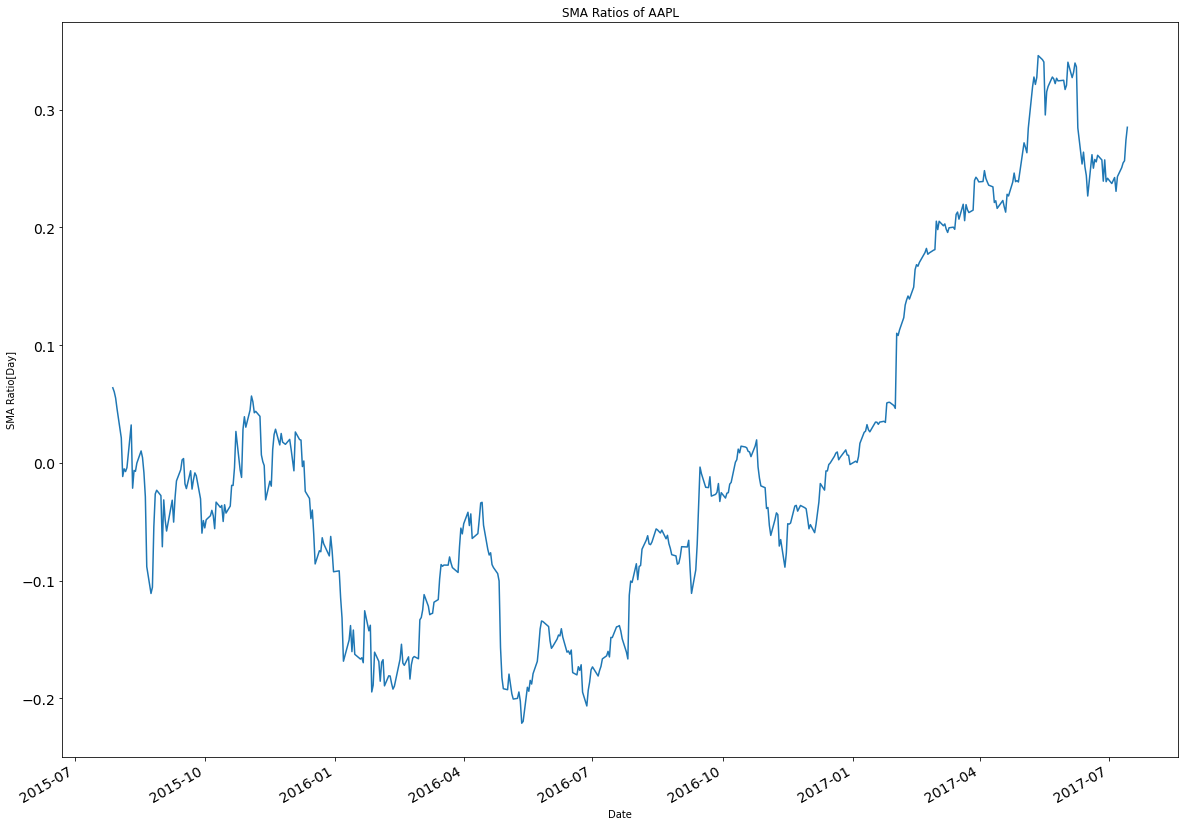

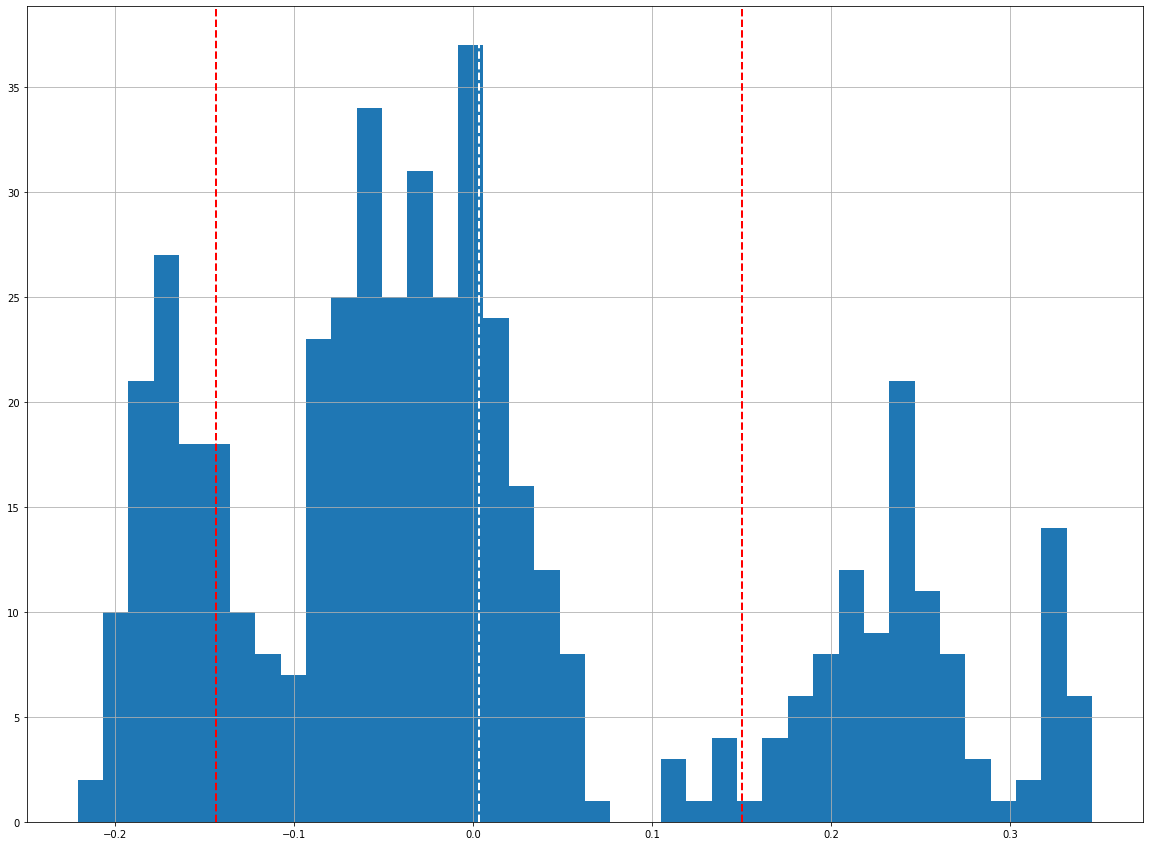

Max/Min SMA Ratio for AAPL
Max:  0.34595194748974367
Min:  -0.22105516413358983


In [17]:
for symbol in tickers:
    sma_ratios = get_sma_ratio(df_explore[symbol], window=metrics_window)

    plot_data(sma_ratios, title='SMA Ratios of ' + symbol, xlabel='Date', ylabel='SMA Ratio[Day]')
    plot_hist_with_stats(sma_ratios, bins=40)

    print ('Max/Min SMA Ratio for ' + symbol)
    print ('Max: ', sma_ratios.max())
    print ('Min: ', sma_ratios.min())

## Bolinger Ratios
---

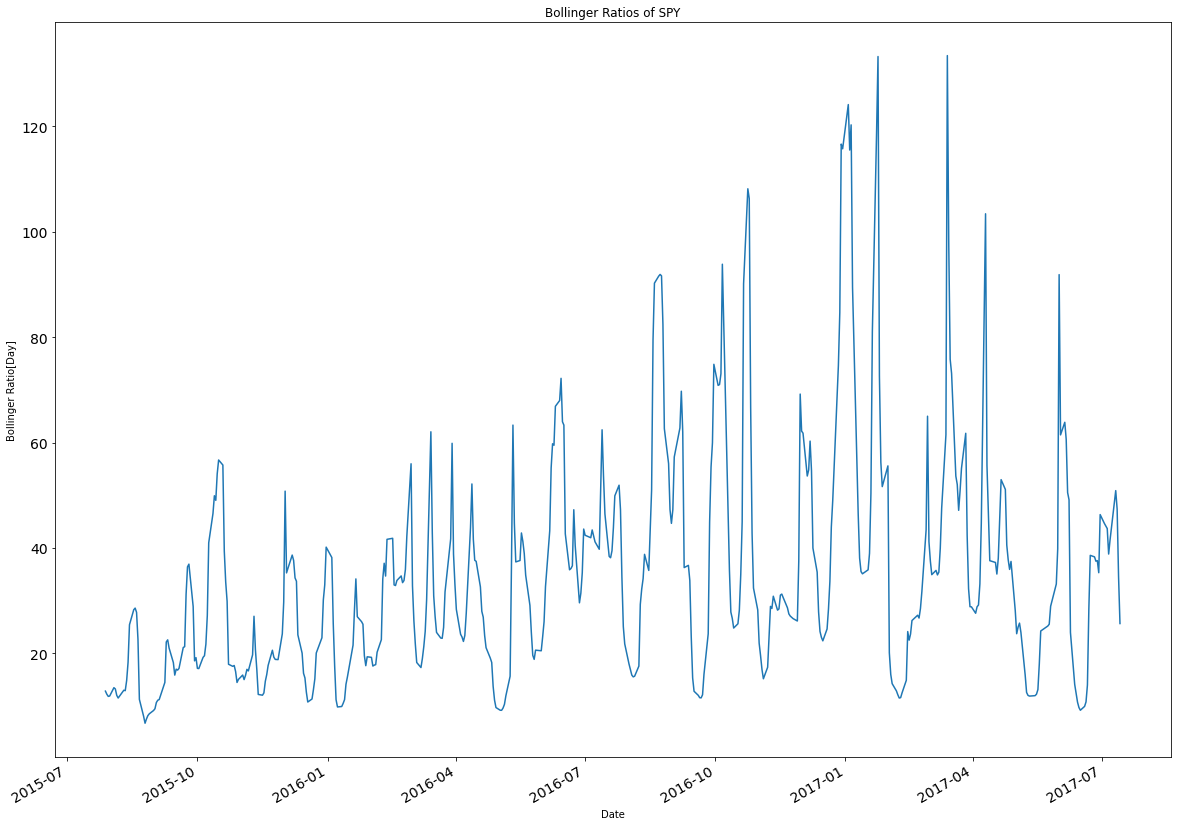

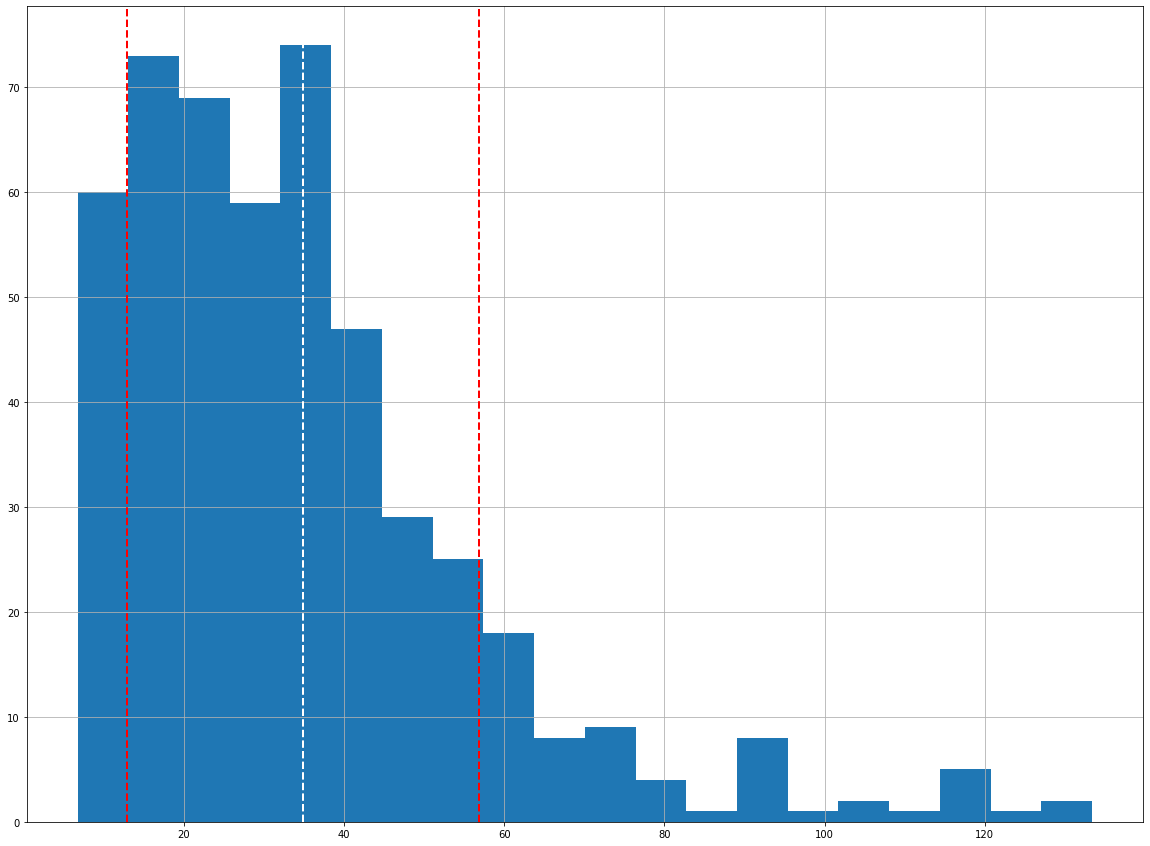

Max/Min BB Ratio for SPY
Max: 133.38263105350867
Min: 6.763255221886609


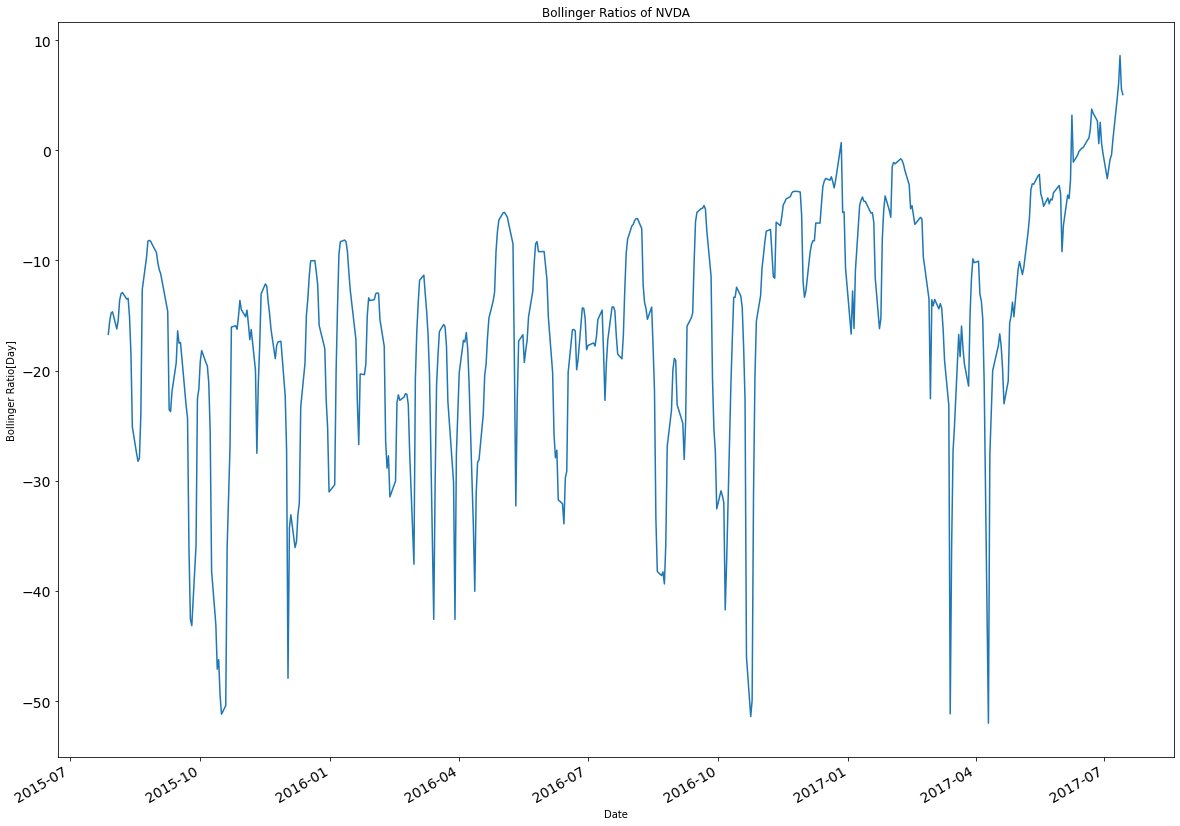

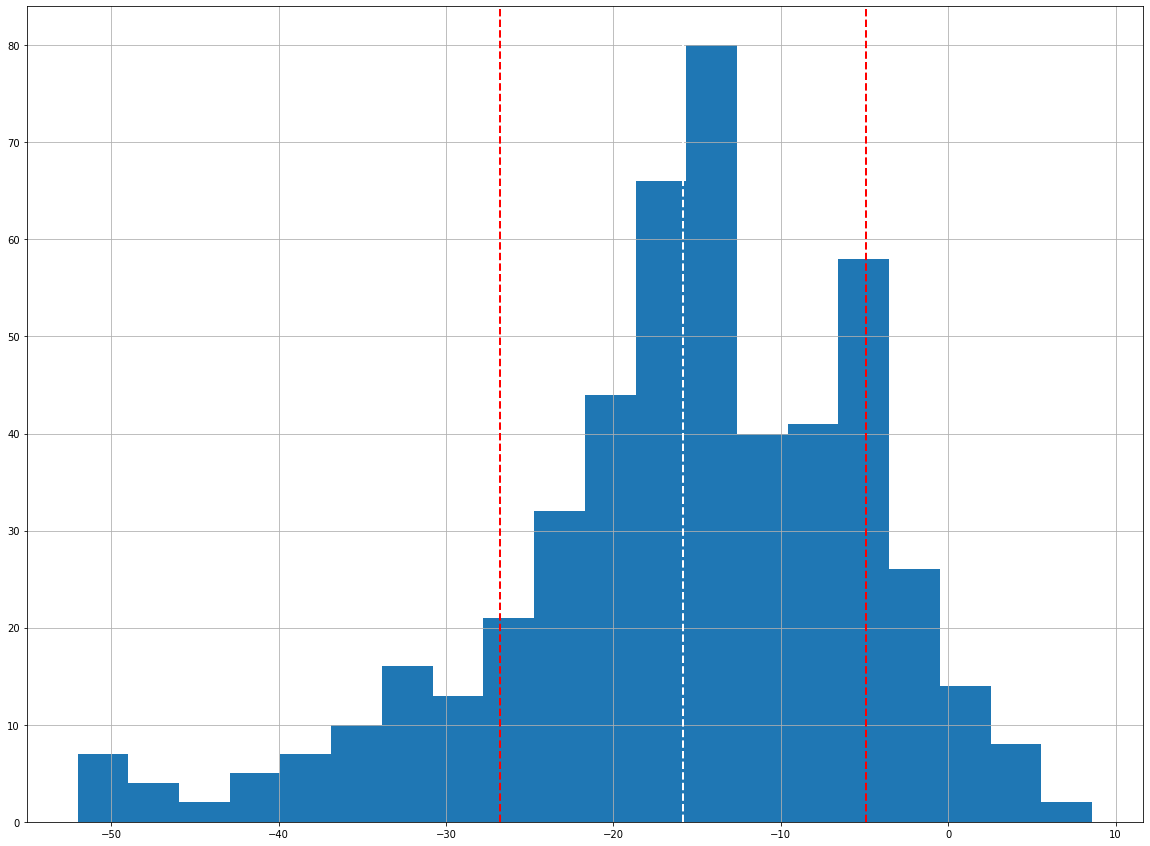

Max/Min BB Ratio for NVDA
Max: 8.596369687048607
Min: -52.01335317677029


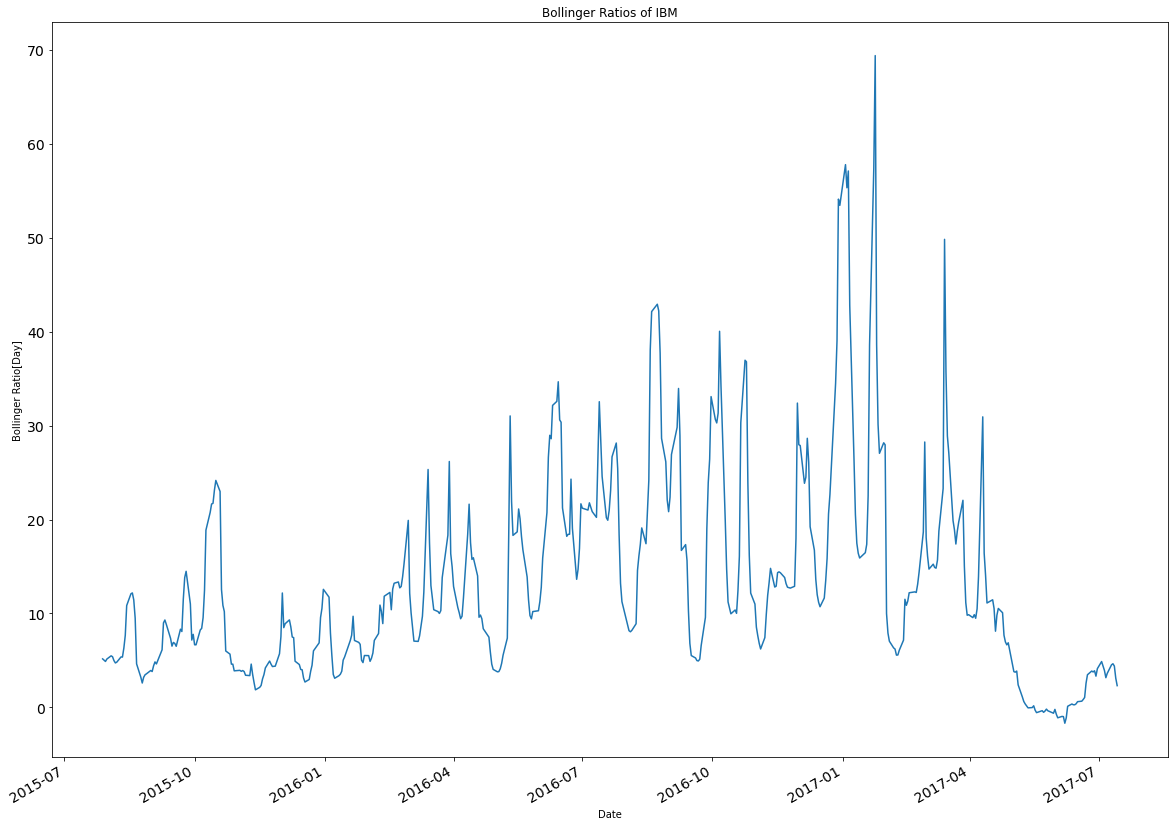

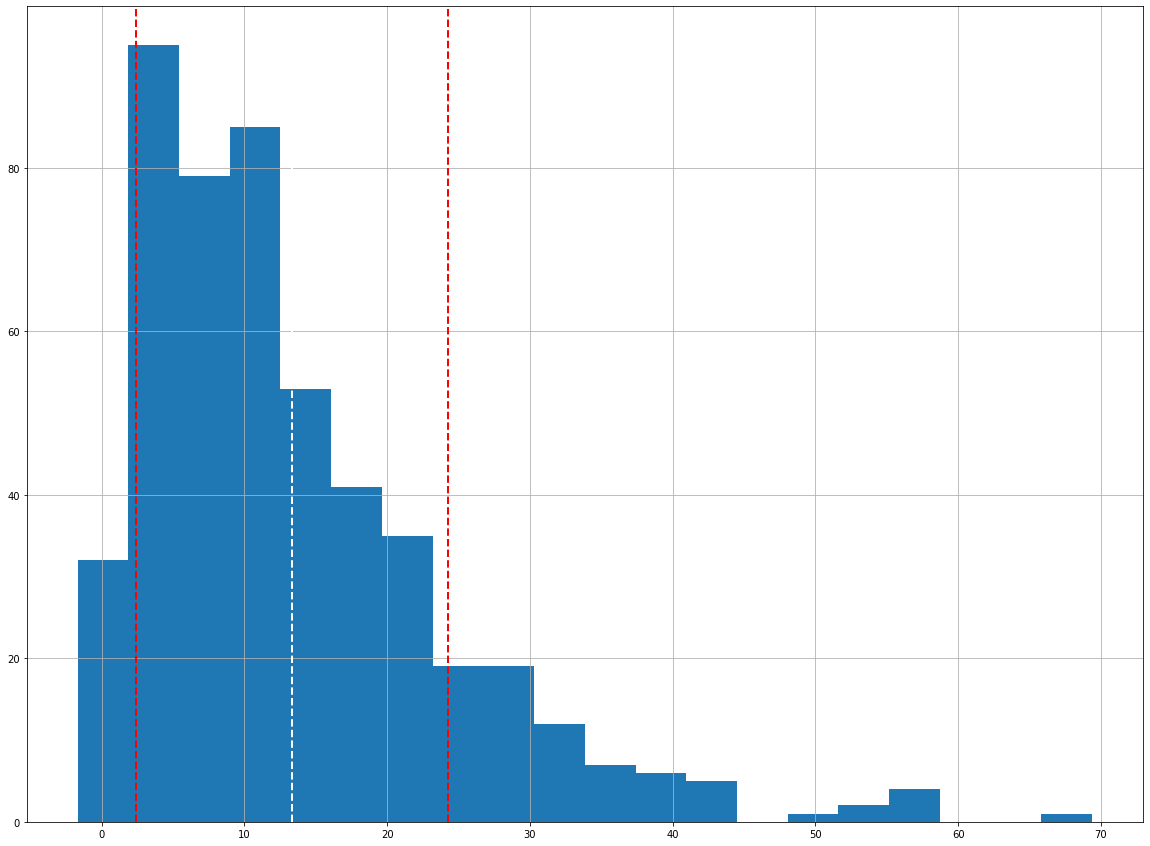

Max/Min BB Ratio for IBM
Max: 69.38210583967908
Min: -1.679650497954864


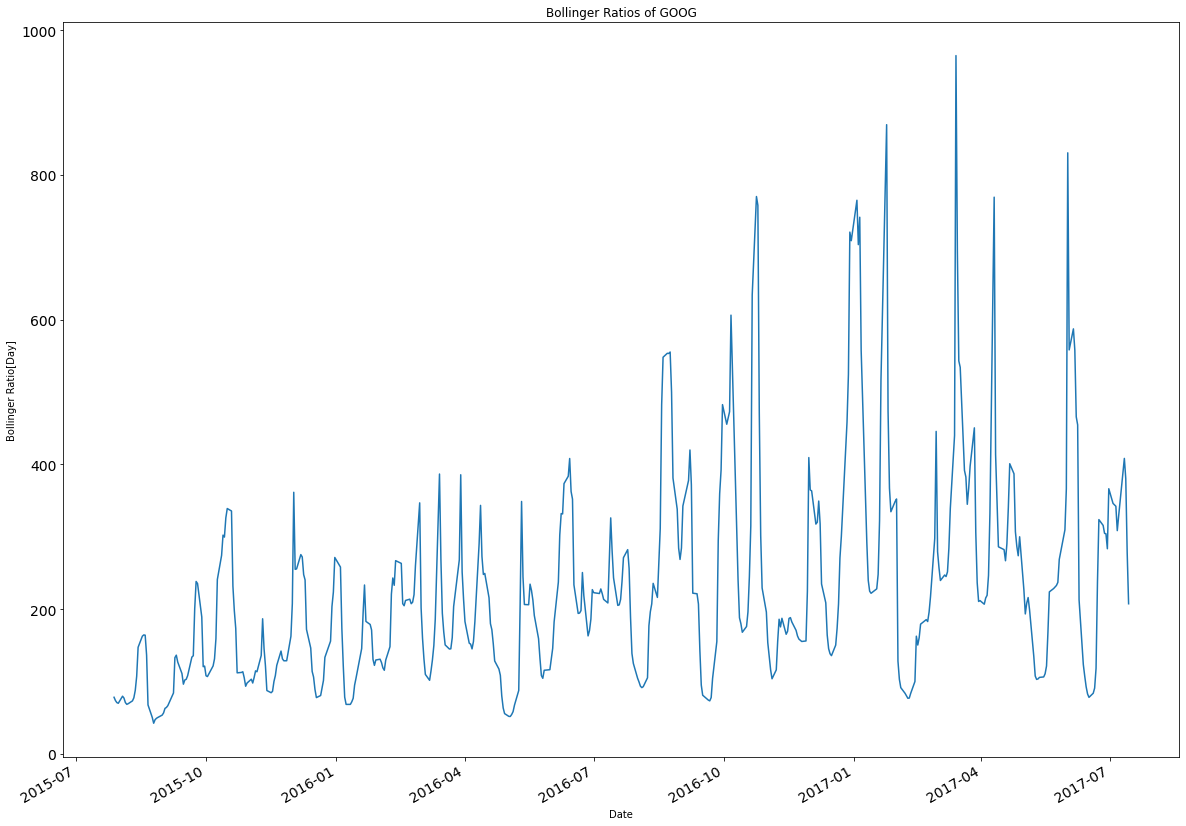

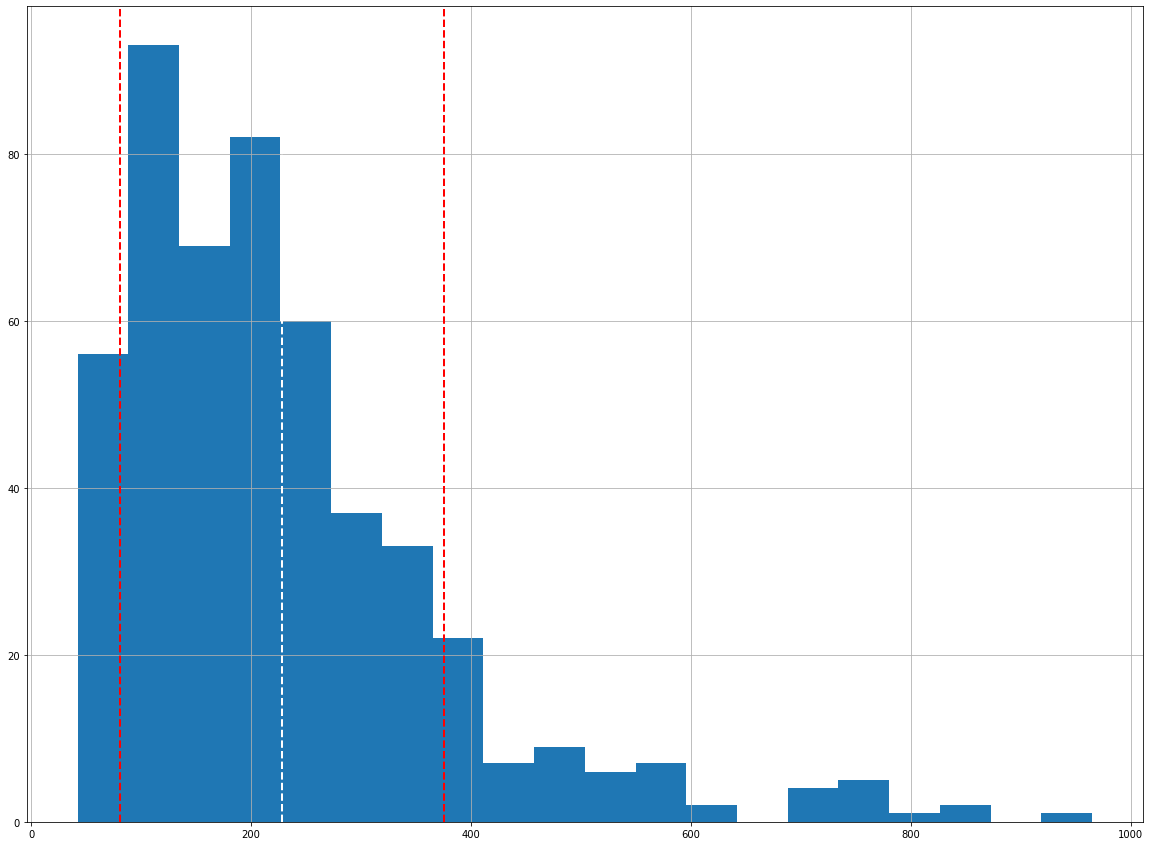

Max/Min BB Ratio for GOOG
Max: 964.763746296129
Min: 42.25009593384634


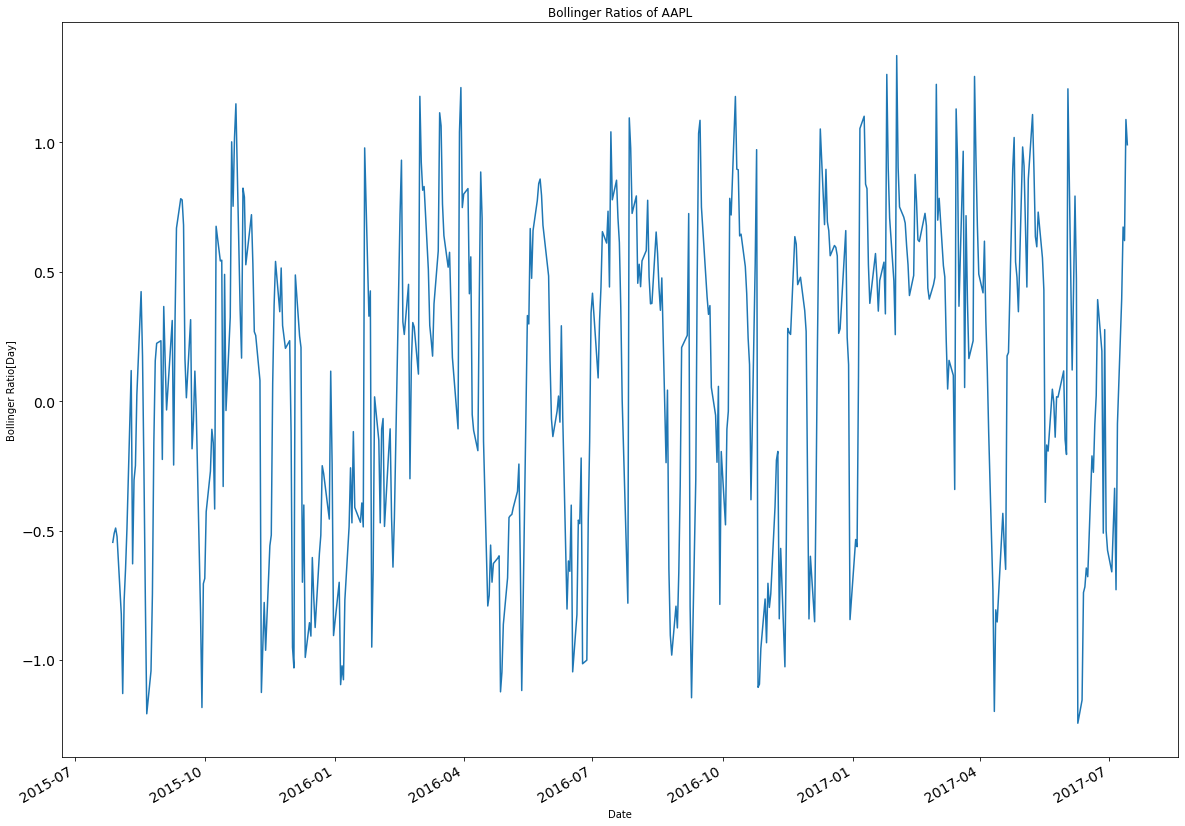

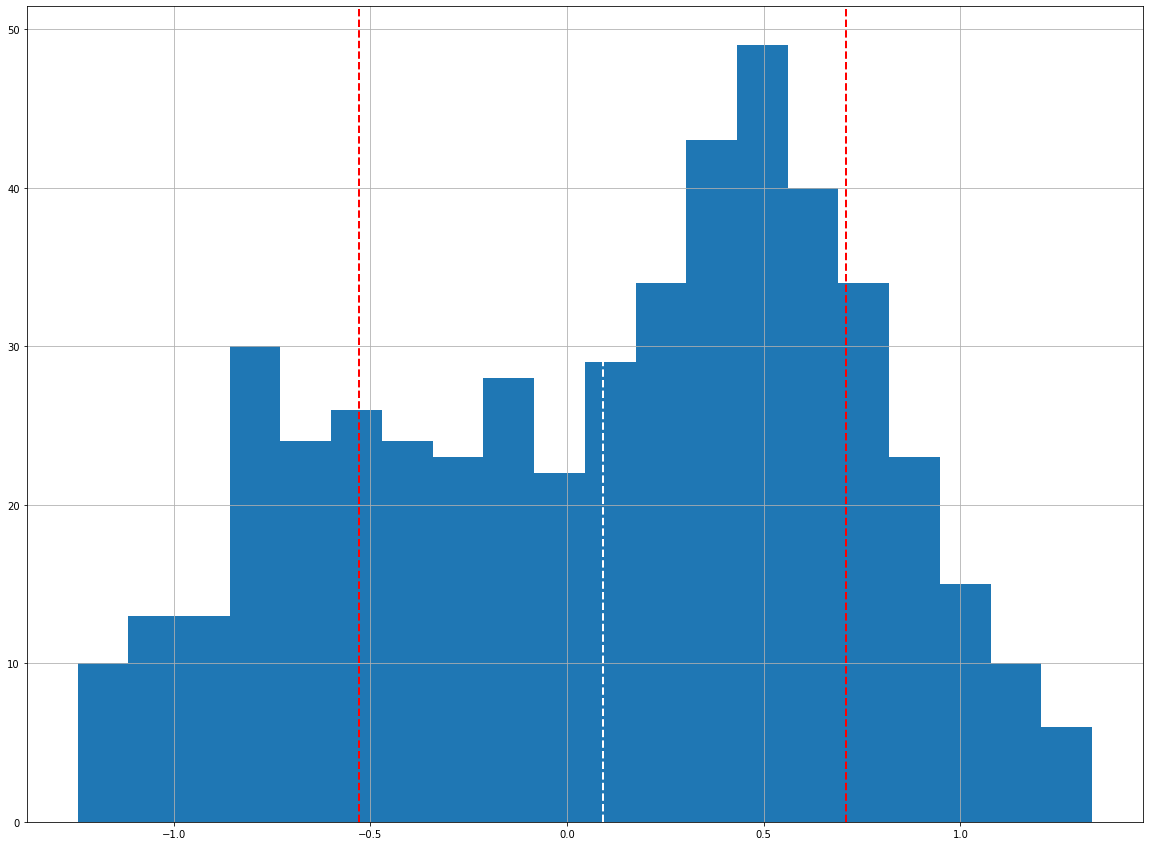

Max/Min BB Ratio for AAPL
Max: 1.334962589510981
Min: -1.2444768657886158


In [18]:
for symbol in tickers:
    bb_ratios = get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window)

    plot_data(bb_ratios, title='Bollinger Ratios of ' + symbol, xlabel='Date', ylabel='Bollinger Ratio[Day]')
    plot_hist_with_stats(bb_ratios, bins=20, title=symbol)

    print ('Max/Min BB Ratio for ' + symbol)
    print ('Max:', bb_ratios.max())
    print ('Min:', bb_ratios.min())

## Example Set Up of the Feature Set
---


In [19]:
# The final features to be used will be the Bollinger Bands Ratio,
# the momentum, and the Simple Moving Average Ratio. The three values
# are easlity converted into numerical values suitable for Machine Learning
# aglorithms

# This is an example set of features to be passed to the ML algos in the following sections

# recombine the features into a new Data Frame X and Y. 
# X will be a frame of all the featres for and Y will be the outcomes

# NVDA as the example
rolling_mean = get_rolling_mean(df_explore['SPY'], metrics_window)
rolling_std = get_rolling_std(df_explore['SPY'], metrics_window)

d = { 
    'BB_RATIOS' : get_bollinger_ratios(series=df_explore['SPY'], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
    'SMA_RATIOS' : get_sma_ratio(df_explore['SPY'], window=metrics_window), 
    'MOMENTUM' : get_momentum(df_explore['SPY'], window=metrics_window)
}
features_df = pd.DataFrame(d)

X_features = features_df[0 : -1].values
y_target = df_explore['SPY'][(metrics_window + 1) : ].values

print ('Features Length', len(X_features))
print ('Target Length', len(y_target))
print (features_df.head())


Features Length 495
Target Length 495
            BB_RATIOS  SMA_RATIOS  MOMENTUM
2015-07-28  -0.305356   -0.025181 -0.006408
2015-07-29   0.053972   -0.018476  0.000760
2015-07-30   0.108938   -0.018243 -0.006971
2015-07-31   0.082941   -0.019733 -0.009319
2015-08-03  -0.045573   -0.023039 -0.013171


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  i

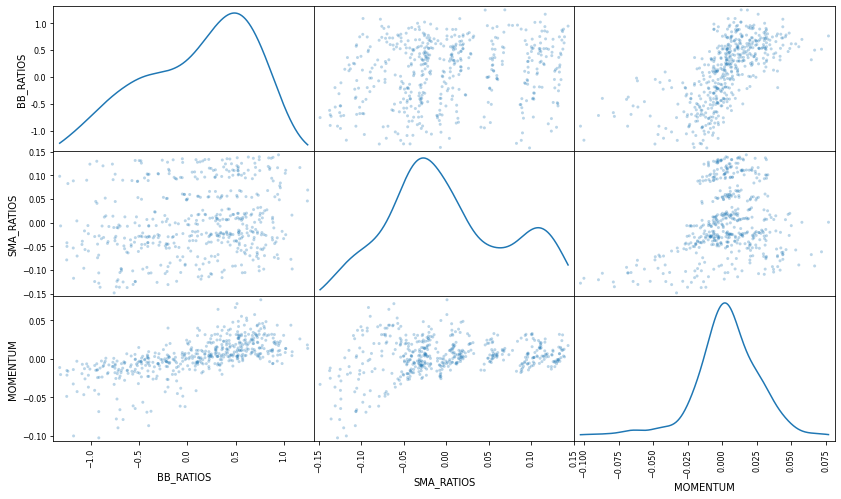

In [21]:
pd.plotting.scatter_matrix(features_df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Machine Learning Algos
---
The final following sections will run each test stock through a few different machine learning algorithms to determine the best model to be used for our predictions. The chosen algos that are believed to be the best fit for the data type are KNN, a simple linear regression, and a Random Forrest.

## KNN
---

KNN Evaluation and scores for  SPY

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [0.8231670247555913, -1.2174454751979433, -5.46959006285846]
Test Scores Mean -1.9546228377669372, Test Scores STD 2.6213572551692064

Predictions [226.25392135 223.64819328 225.55823248 224.79312837 226.12281596
 225.9735832  226.43136578 226.54049371 225.81384982 225.98462388
 225.89051164 226.03054659]

Actual [225.910004 226.740005 226.149994 227.600006 229.570007 229.330002
 228.970001 227.550003 227.529999 227.619995 227.770004 229.339996]


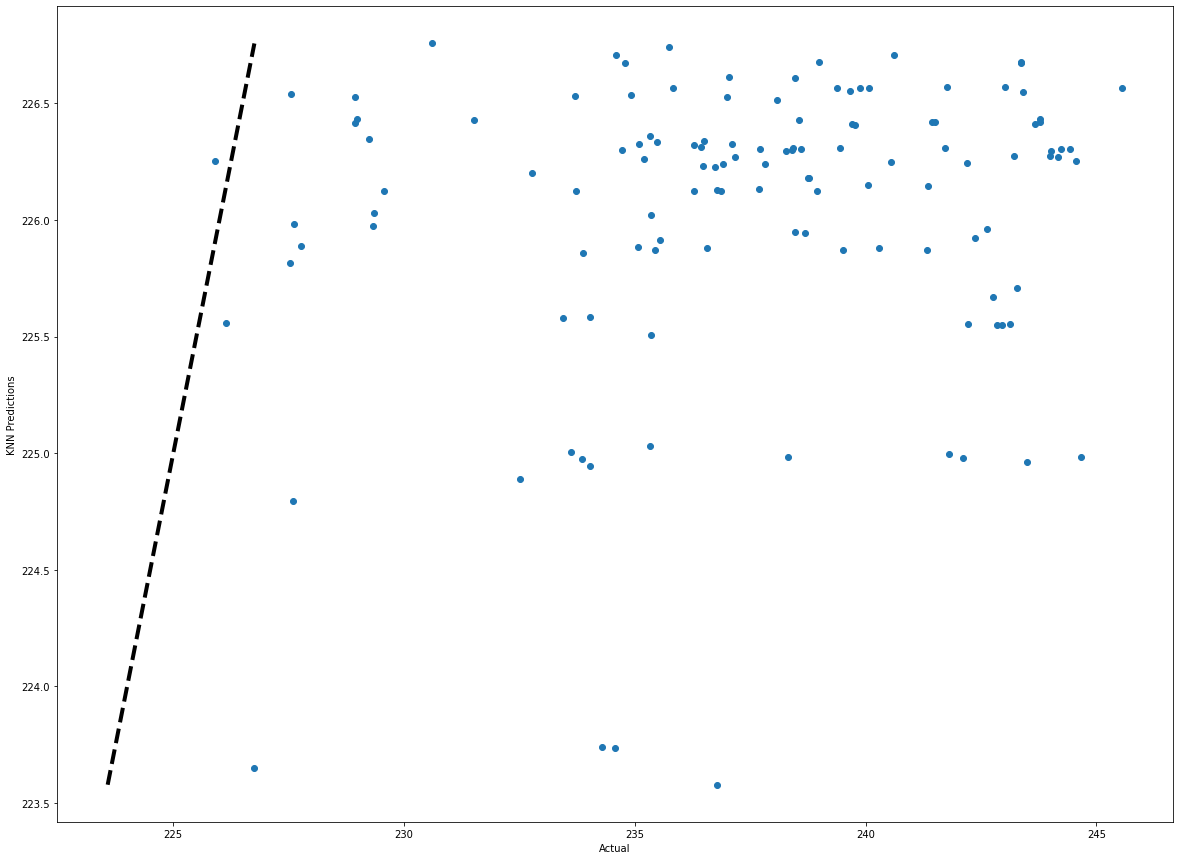




KNN Evaluation and scores for  NVDA

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [-0.520432398707948, -1.863380282096134, -0.49238335920927906]
Test Scores Mean -0.9587320133377871, Test Scores STD 0.6397854092218762

Predictions [103.0447412   98.02578497 102.78822739  98.96791568  96.71331608
  99.25947728 101.88215811 103.90600754  99.79825646  99.95471238
 105.94952871 106.02499425]

Actual [105.160004 104.010002 105.089996 107.330002 107.790001 109.650002
 111.769997 110.019997 109.18     113.949997 115.389999 114.379997]


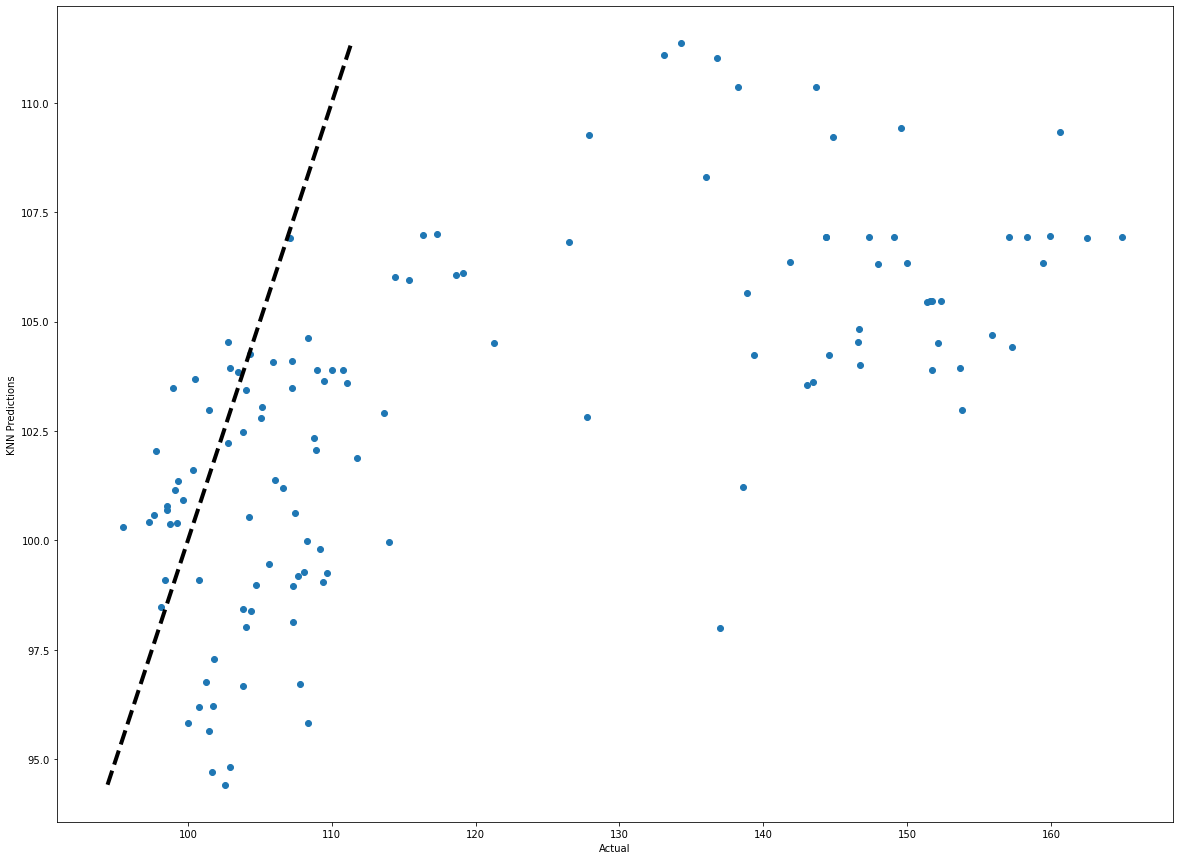




KNN Evaluation and scores for  IBM

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [0.7323490803778744, -0.3134207310434818, 0.6093823035040902]
Test Scores Mean 0.34277021761282755, Test Scores STD 0.46670485168361114

Predictions [166.72461338 165.57582057 168.03192946 168.0247495  167.76677257
 164.36985435 166.68423119 167.42558004 167.24556407 167.09925139
 167.1061623  167.11760085]

Actual [166.809998 170.550003 171.029999 175.899994 178.289993 178.660004
 177.300003 175.800003 174.520004 174.289993 174.580002 175.820007]


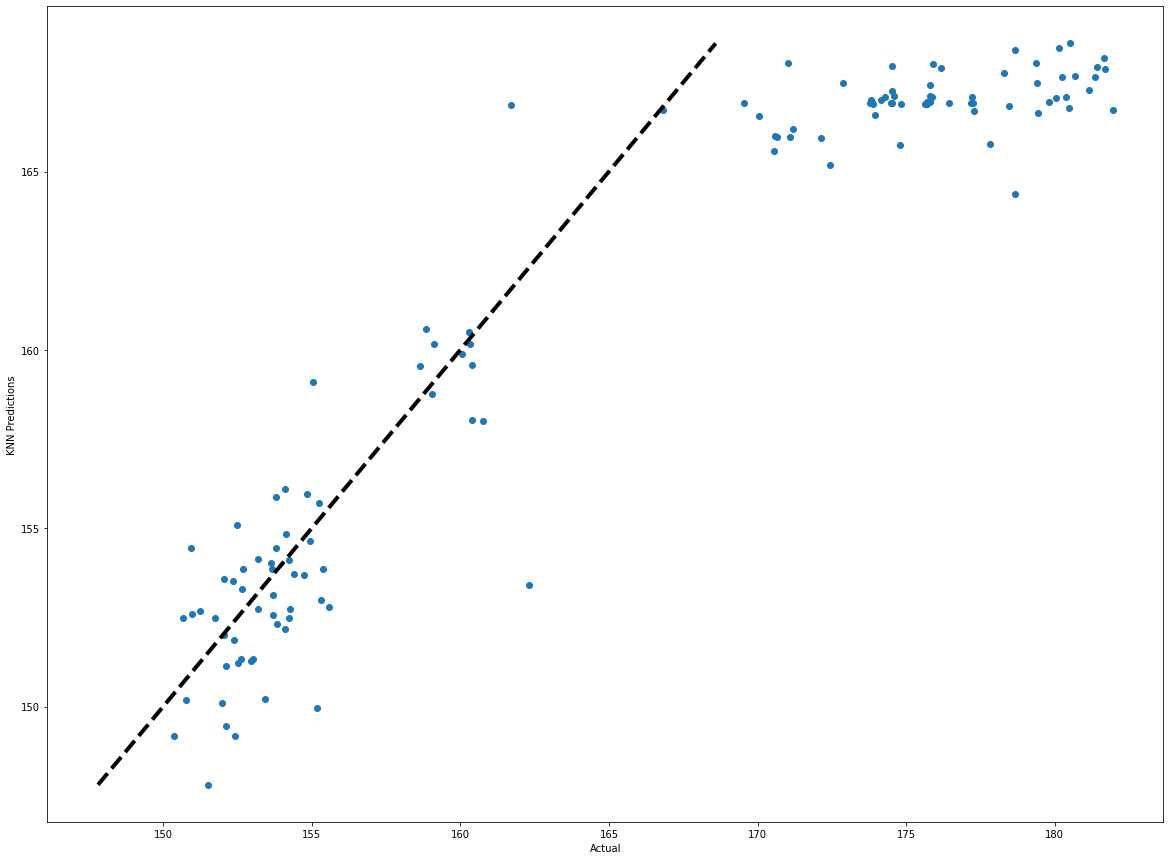




KNN Evaluation and scores for  GOOG

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [0.3146753651825249, -3.0835618444051294, -1.874160633186042]
Test Scores Mean -1.5476823708028824, Test Scores STD 1.4064008615405654

Predictions [799.76001584 787.07999835 786.83072133 795.34169446 803.78667608
 803.67488973 805.07585016 804.46613881 780.87597665 778.42181447
 777.9493481  782.51665344]

Actual [802.174988 805.02002  819.309998 823.869995 835.669983 832.150024
 823.309998 802.320007 796.789978 795.695007 798.530029 801.48999 ]


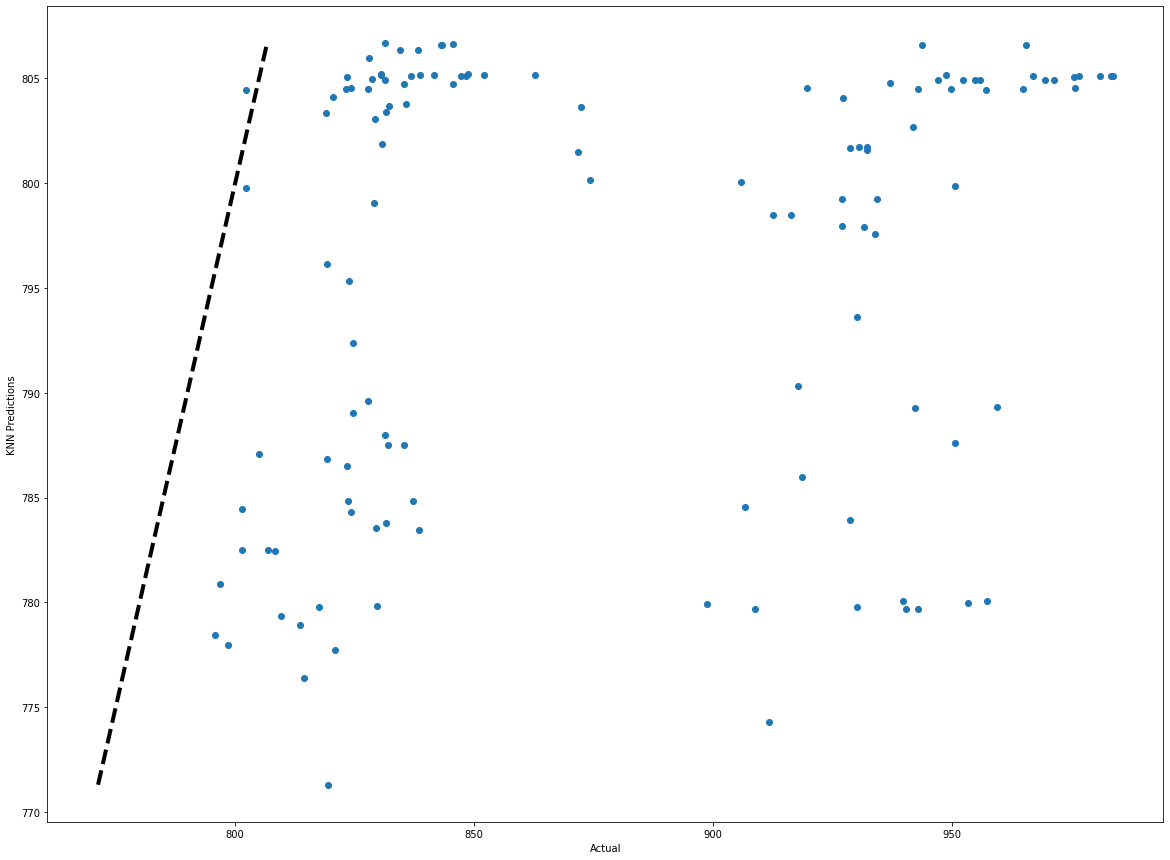




KNN Evaluation and scores for  AAPL

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [0.6706932273390492, 0.8156092157406555, -6.049321439486139]
Test Scores Mean -1.521006332135478, Test Scores STD 3.2025488228928713

Predictions [119.05224974 119.45291805 119.00114849 118.90742324 118.58146803
 117.95747931 118.6416734  119.25394771 119.49890234 119.2140557
 119.88608898 121.16494943]

Actual [119.779999 120.       120.080002 119.970001 121.879997 121.940002
 121.949997 121.629997 121.349998 128.75     128.529999 129.080002]


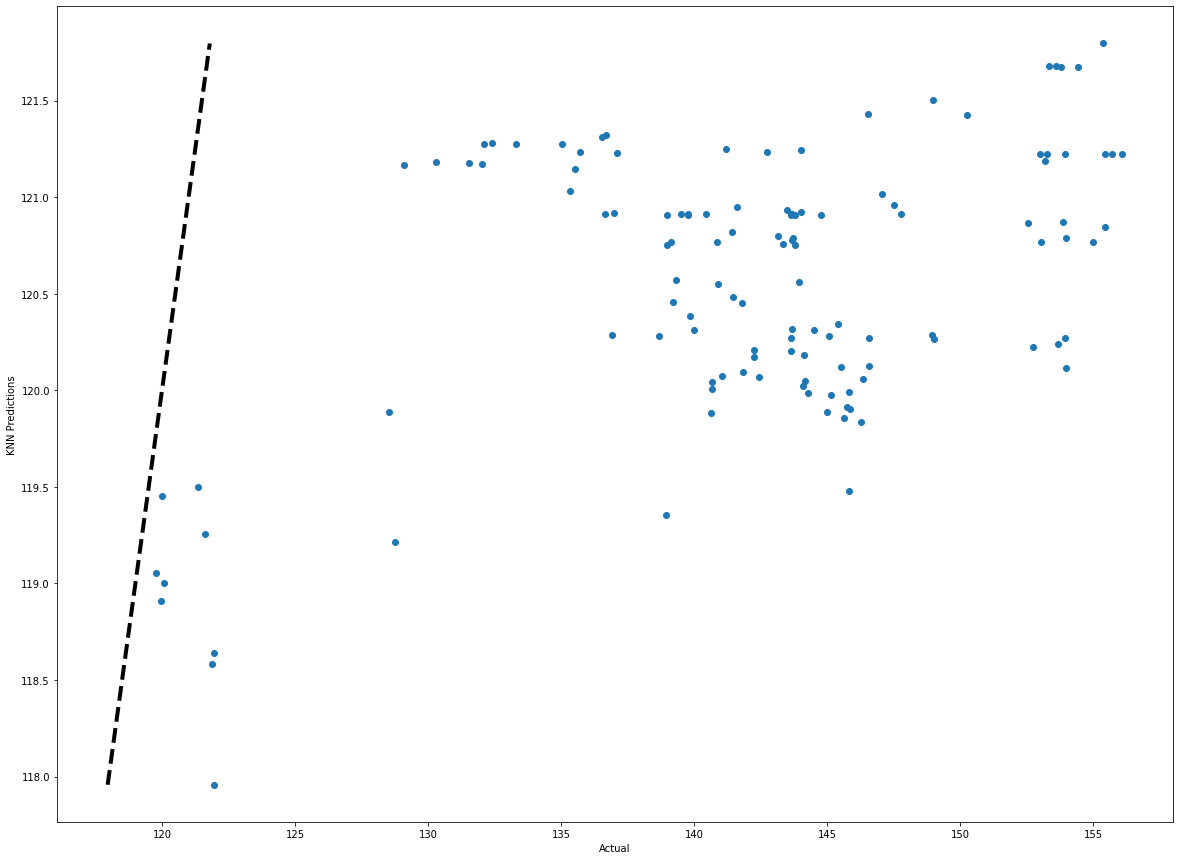

In [23]:
for symbol in tickers:
    
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)

    d = { 
        'BB_RATIOS' : get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
        'SMA_RATIOS' : get_sma_ratio(df_explore[symbol], window=metrics_window), 
        'MOMENTUM' : get_momentum(df_explore[symbol], window=metrics_window)
    }
    features_df = pd.DataFrame(d)

    X_features = features_df[0 : -1].values
    y_target = df_explore[symbol][(metrics_window + 1) : ].values


    pipe_knn = Pipeline([
            ('scl', StandardScaler()),
            ('clf', KNeighborsRegressor(n_neighbors=5, weights='distance'))
        ])

    tscv = TimeSeriesSplit(n_splits=3)
    train_scores = []
    test_scores = []

    final_predics = []
    actual_vals = []

    for train_index, test_index in tscv.split(X_features):
        
        pipe_knn.fit(X_features[train_index], y_target[train_index])

        train_score = pipe_knn.score(X_features[train_index], y_target[train_index])
        test_score = pipe_knn.score(X_features[test_index], y_target[test_index])

        train_scores.append(train_score)
        test_scores.append(test_score)

        final_predic = pipe_knn.predict(X_features[test_index])
        actual_vals = y_target[test_index]
    
    print ('KNN Evaluation and scores for ', symbol)
    print ('\nTrain scores', train_scores)
    print ('Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std()))

    print ('\nTest scores', test_scores)
    print ('Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std()))

    print ('\nPredictions', final_predic[0: 12])

    print ('\nActual', actual_vals[0: 12])

    plot_predictions(actual_vals, final_predic, y_label='KNN Predictions')
    print ('\n\n')

## Linear Regression 
---

Linear Regression Evaluation and scores for  SPY

Train scores [0.8897979185086836, 0.9202425674821053, 0.9638761290040812]
Train Scores Mean 0.9246388716649566, Train Scores STD 0.03040165494838753

Test scores [0.9395818853745148, 0.9163868614557265, 0.9419665402177663]
Test Scores Mean 0.9326450956826692, Test Scores STD 0.011537454364343391

Predictions [226.58824881 225.77857694 226.59870442 226.02834155 227.44971854
 229.37080098 229.14159813 228.77707752 227.39614487 227.36200677
 227.45815312 227.58919429]

Actual [225.910004 226.740005 226.149994 227.600006 229.570007 229.330002
 228.970001 227.550003 227.529999 227.619995 227.770004 229.339996]


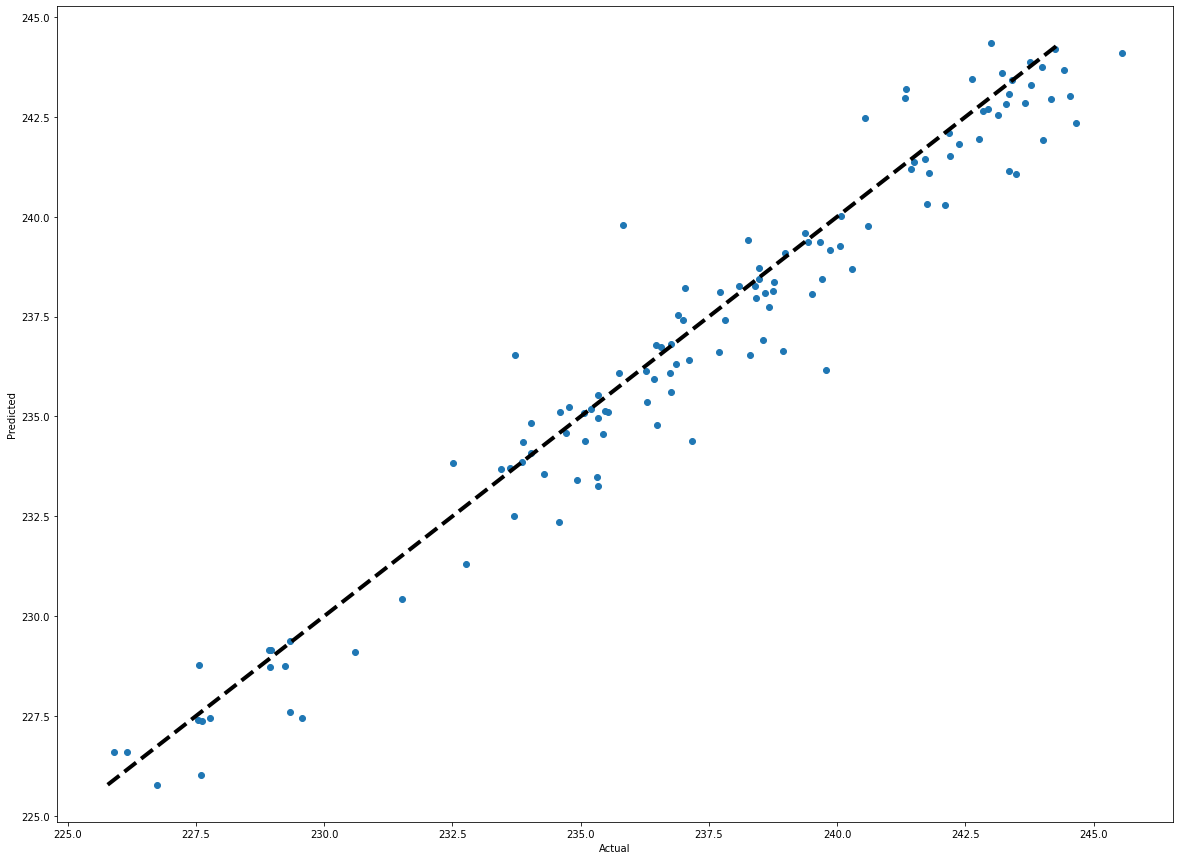




Linear Regression Evaluation and scores for  NVDA

Train scores [0.9761266496798117, 0.9921758396658559, 0.9951941654268076]
Train Scores Mean 0.9878322182574917, Train Scores STD 0.008368306256142245

Test scores [0.9848695879977788, 0.976610173841059, 0.9719465831243818]
Test Scores Mean 0.9778087816544065, Test Scores STD 0.005343438921214453

Predictions [103.46985738 105.61210732 104.4990622  105.55007289 107.72155195
 108.17624879 110.01185235 112.1165844  110.42505462 109.60029508
 114.29256218 115.7510993 ]

Actual [105.160004 104.010002 105.089996 107.330002 107.790001 109.650002
 111.769997 110.019997 109.18     113.949997 115.389999 114.379997]


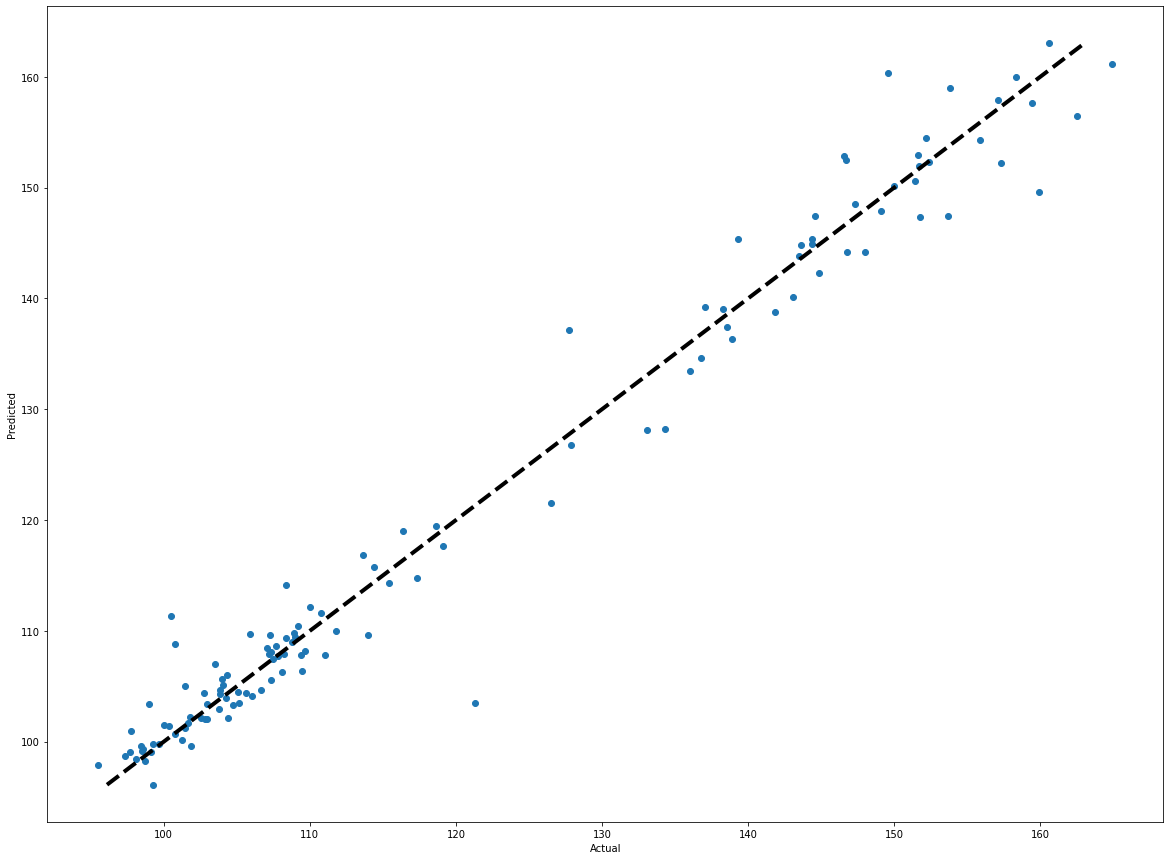




Linear Regression Evaluation and scores for  IBM

Train scores [0.9449664966199423, 0.9535686449175171, 0.9724263166403978]
Train Scores Mean 0.9569871527259525, Train Scores STD 0.011468073817231398

Test scores [0.9526118936443625, 0.916442529676288, 0.9835980067294746]
Test Scores Mean 0.9508841433500418, Test Scores STD 0.0274433157055279

Predictions [166.6791059  166.63390005 170.14031948 170.61861169 175.50290927
 177.98255998 178.35637984 177.0369731  175.58449259 174.32467523
 174.13638946 174.44606738]

Actual [166.809998 170.550003 171.029999 175.899994 178.289993 178.660004
 177.300003 175.800003 174.520004 174.289993 174.580002 175.820007]


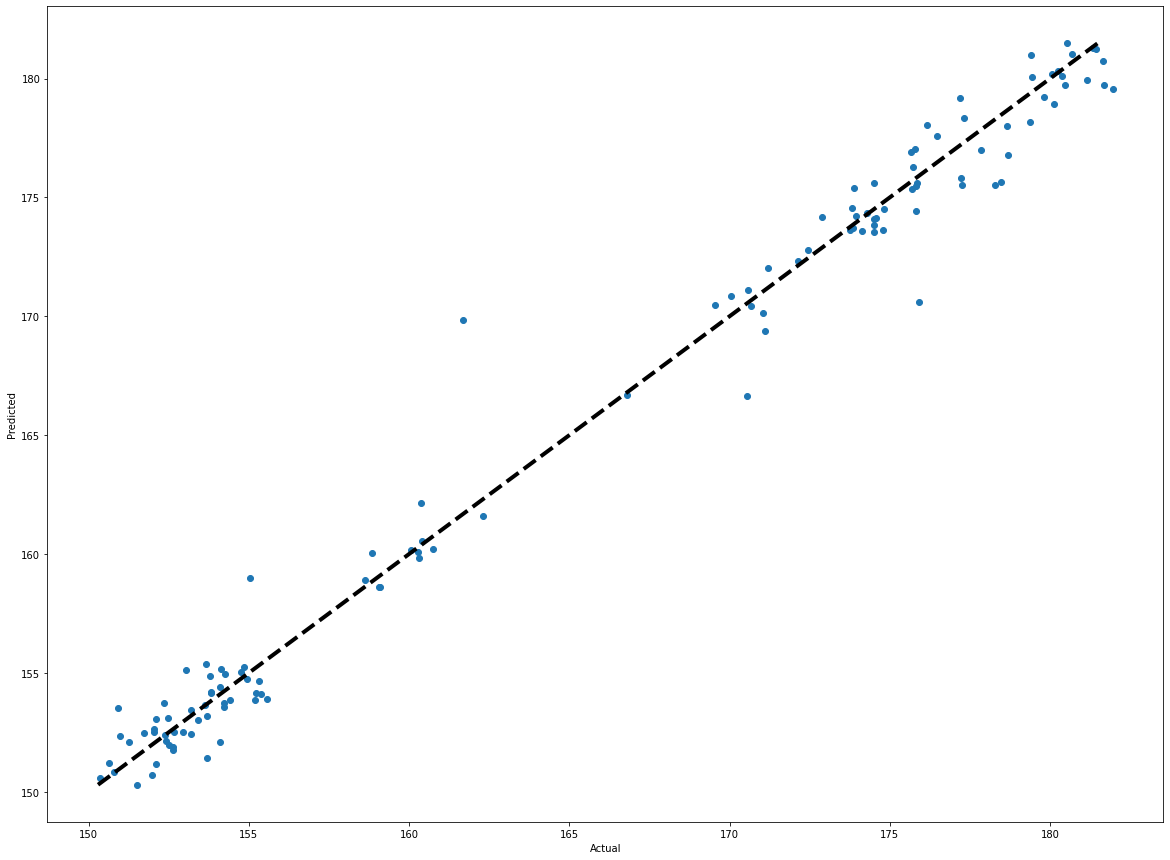




Linear Regression Evaluation and scores for  GOOG

Train scores [0.9531754765914444, 0.941344375464054, 0.9642257622000752]
Train Scores Mean 0.9529152047518578, Train Scores STD 0.009343099800162768

Test scores [0.7946038429942905, 0.7608918897037176, 0.9745513518277652]
Test Scores Mean 0.8433490281752577, Test Scores STD 0.09378934284707557

Predictions [804.8449382  801.05137424 803.97450571 818.22602982 822.56517124
 833.82409185 830.47026688 821.89261561 801.69157451 796.2904452
 795.28520356 797.92317337]

Actual [802.174988 805.02002  819.309998 823.869995 835.669983 832.150024
 823.309998 802.320007 796.789978 795.695007 798.530029 801.48999 ]


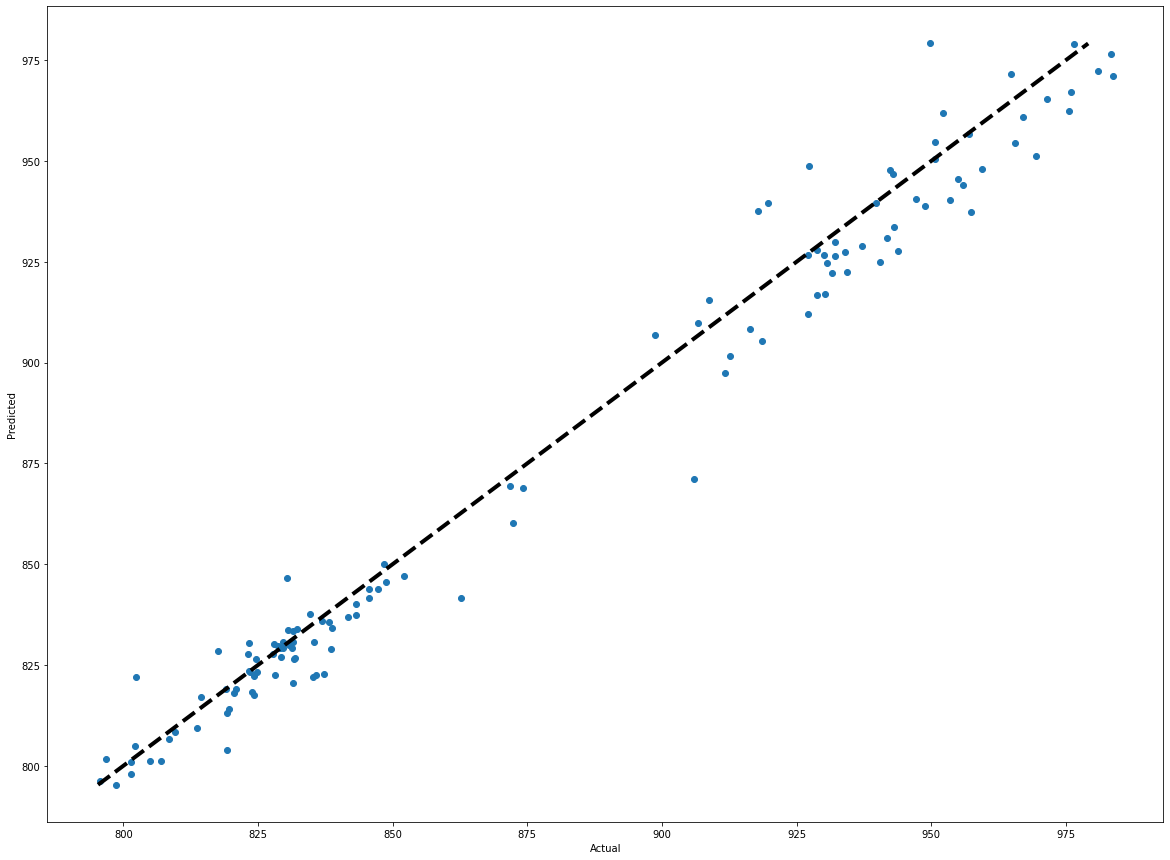




Linear Regression Evaluation and scores for  AAPL

Train scores [0.8910880015972578, 0.9556700812407342, 0.9572957361754912]
Train Scores Mean 0.9346846063378278, Train Scores STD 0.030834597961498164

Test scores [0.932807082060844, 0.9173914527613737, 0.9545808131612525]
Test Scores Mean 0.9349264493278234, Test Scores STD 0.015256275647467774

Predictions [119.7384258  119.51754414 119.74411435 119.82360696 119.68504534
 121.66890583 121.67941878 121.6682704  121.32610893 121.02084773
 128.40034624 128.13283416]

Actual [119.779999 120.       120.080002 119.970001 121.879997 121.940002
 121.949997 121.629997 121.349998 128.75     128.529999 129.080002]


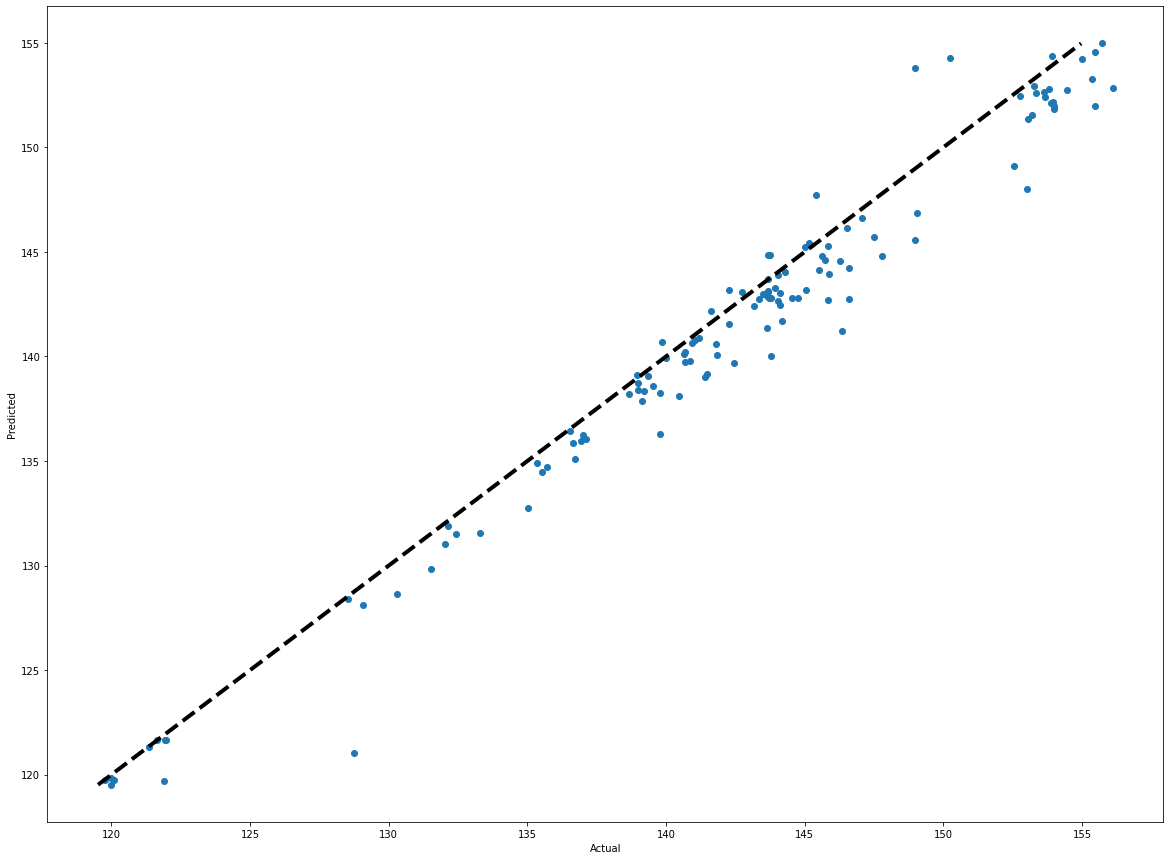

In [24]:
for symbol in tickers:
        
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)

    d = { 
        'BB_RATIOS' : get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
        'SMA_RATIOS' : get_sma_ratio(df_explore[symbol], window=metrics_window), 
        'MOMENTUM' : get_momentum(df_explore[symbol], window=metrics_window)
    }
    features_df = pd.DataFrame(d)

    X_features = features_df[0 : -1].values
    y_target = df_explore[symbol][(metrics_window + 1) : ].values
    
    pipe_lr = Pipeline([
            ('scl', StandardScaler()),
            ('clf', LinearRegression())
        ])

    tscv = TimeSeriesSplit(n_splits=3)
    train_scores = []
    test_scores = []

    final_predics = []
    actual_vals = []

    for train_index, test_index in tscv.split(X_features):
        pipe_lr.fit(X_features[train_index], y_target[train_index])

        train_score = pipe_lr.score(X_features[train_index], y_target[train_index])
        test_score = pipe_lr.score(X_features[test_index], y_target[test_index])

        train_scores.append(train_score)
        test_scores.append(test_score)

        final_predic = pipe_lr.predict(X_features[test_index])
        actual_vals = y_target[test_index]

    print ('Linear Regression Evaluation and scores for ', symbol)
    print ('\nTrain scores', train_scores)
    print ('Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std()))

    print ('\nTest scores', test_scores)
    print ('Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std()))

    print ('\nPredictions', final_predic[0: 12])

    print ('\nActual', actual_vals[0: 12])

    plot_predictions(actual_vals, final_predic, y_label='Predicted')
    print ('\n\n')

## Random Forests

Random Forests Evaluation and scores for  SPY

Train scores [0.9631773365252901, 0.9821526894115472, 0.9901911480132737]
Train Scores Mean 0.9785070579833702, Train Scores STD 0.01132561916363843

Test scores [0.8364876216528356, -0.15476579304082794, -5.686987164373448]
Test Scores Mean -1.668421778587147, Test Scores STD 2.8702260831875614

Predictions [226.1620024 225.1660004 225.8880004 225.1660004 226.2160036 226.154001
 226.1440034 226.1580018 225.8880004 225.928003  225.928003  225.928003 ]

Actual [225.910004 226.740005 226.149994 227.600006 229.570007 229.330002
 228.970001 227.550003 227.529999 227.619995 227.770004 229.339996]


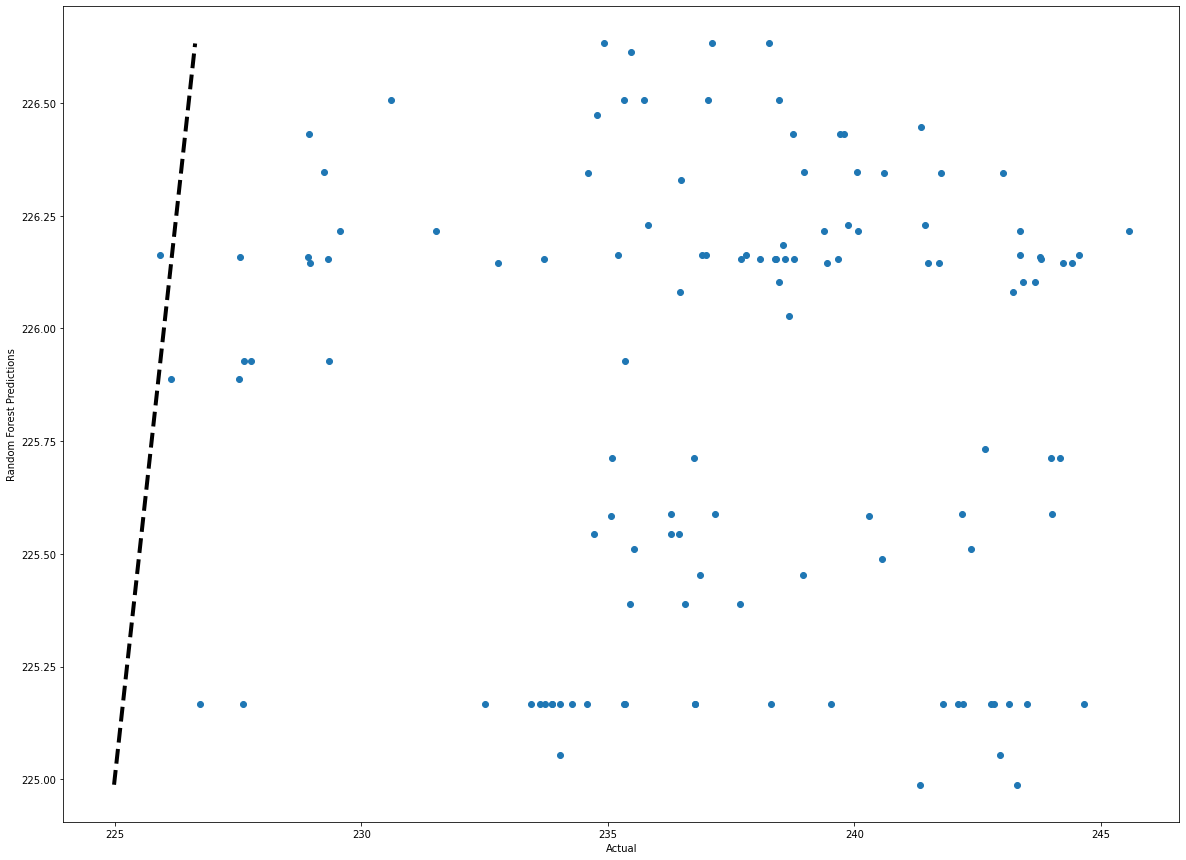




Random Forests Evaluation and scores for  NVDA

Train scores [0.988800801939187, 0.9975567512337964, 0.9979805180520251]
Train Scores Mean 0.9947793570750028, Train Scores STD 0.004231015300772042

Test scores [-0.45714587641604787, -1.6892324123065747, -0.4391374895874174]
Test Scores Mean -0.8618385927700133, Test Scores STD 0.5851019711437869

Predictions [105.401999  105.2900012 105.3240008 105.2900012 105.9240006 105.9240006
 105.3699998 105.4240006 105.4240006 105.9780014 106.4440004 106.4440004]

Actual [105.160004 104.010002 105.089996 107.330002 107.790001 109.650002
 111.769997 110.019997 109.18     113.949997 115.389999 114.379997]


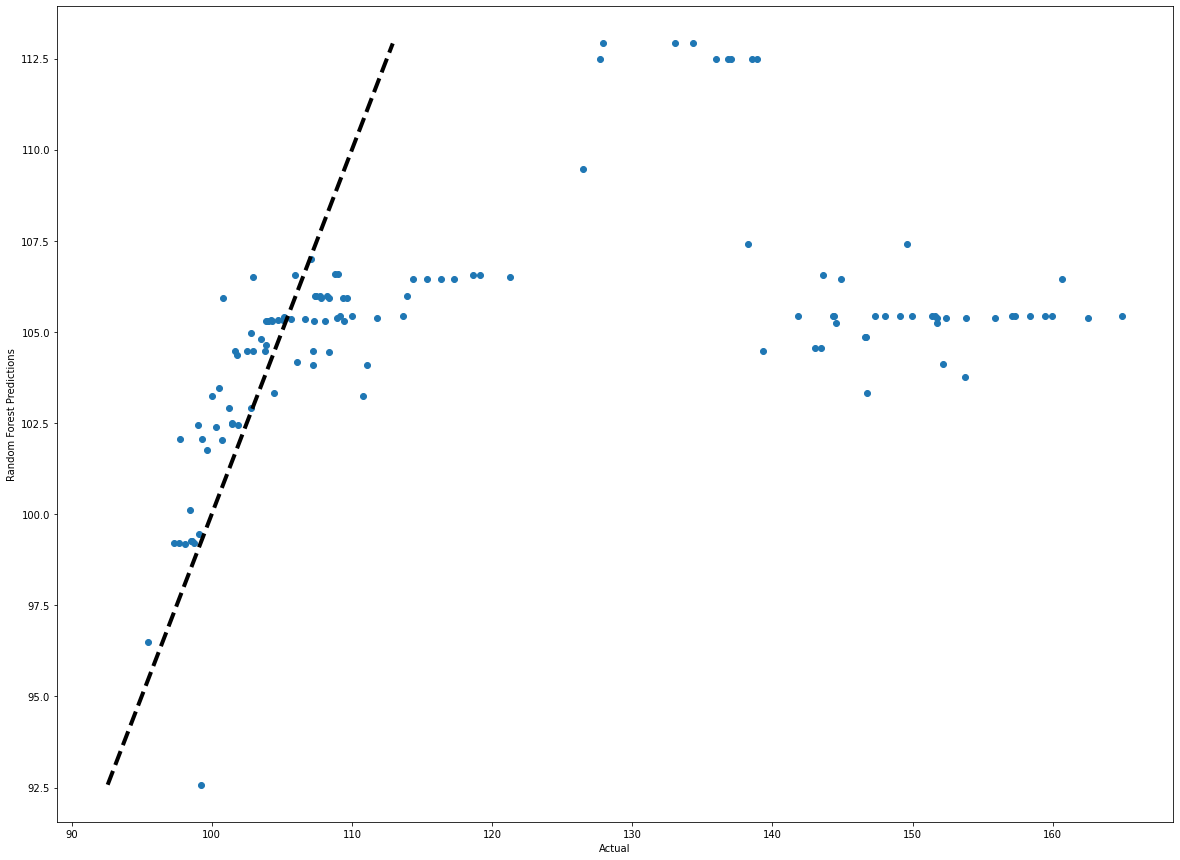




Random Forests Evaluation and scores for  IBM

Train scores [0.9839741019501713, 0.9856003979004425, 0.9931744061456254]
Train Scores Mean 0.9875829686654131, Train Scores STD 0.004009101266768668

Test scores [0.8914139004575842, 0.5149980142521875, 0.6852401699415385]
Test Scores Mean 0.6972173615504368, Test Scores STD 0.153904341905561

Predictions [166.9800014 166.3520046 168.025995  168.401996  167.9339966 167.9339966
 168.173999  168.173999  167.9899994 167.9899994 167.9899994 167.9899994]

Actual [166.809998 170.550003 171.029999 175.899994 178.289993 178.660004
 177.300003 175.800003 174.520004 174.289993 174.580002 175.820007]


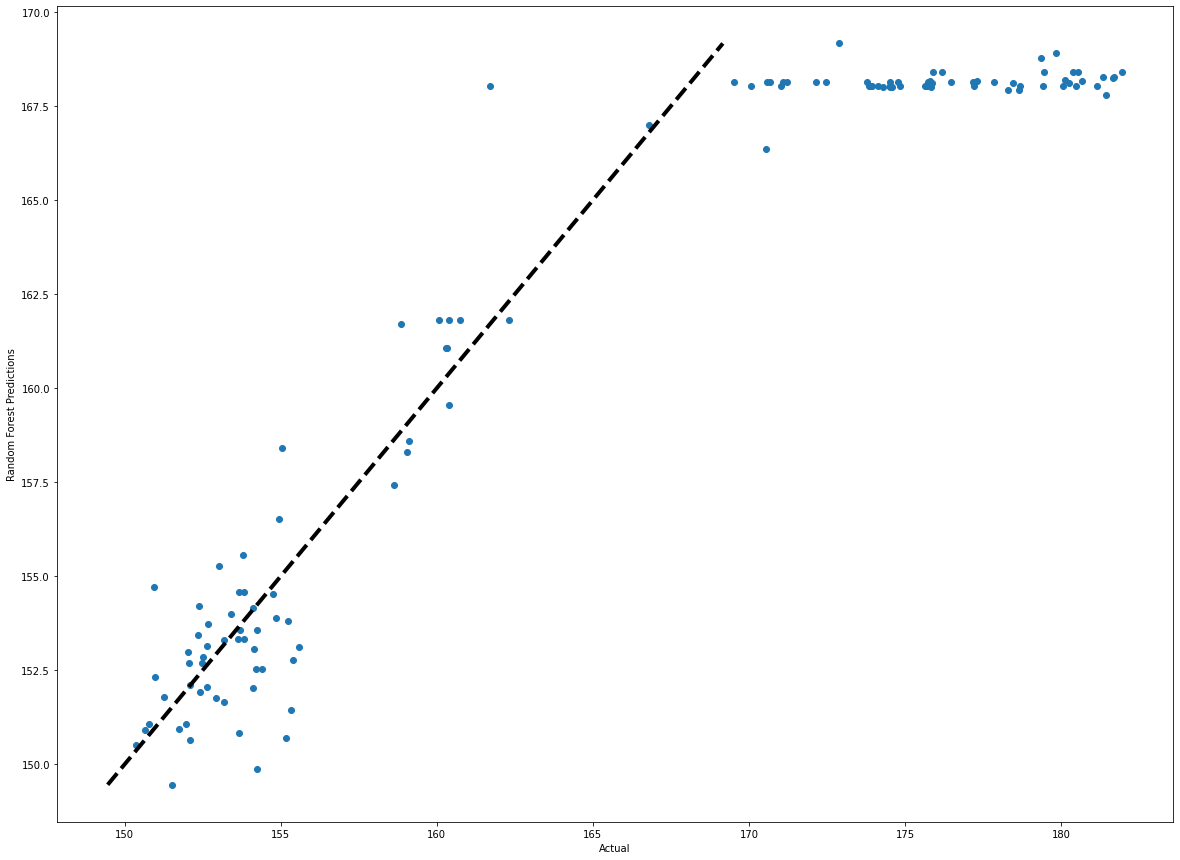




Random Forests Evaluation and scores for  GOOG

Train scores [0.985946905043617, 0.9832015467595652, 0.9872337125161592]
Train Scores Mean 0.9854607214397805, Train Scores STD 0.0016816402795370225

Test scores [0.5444817708762666, -2.1861638626801887, -1.5590744733042246]
Test Scores Mean -1.0669188550360489, Test Scores STD 1.1678382474926146

Predictions [805.9059934 798.0059812 801.237988  804.9180052 804.545996  803.1859864
 803.765979  805.9059934 799.4079832 793.9819824 788.267981  793.9819824]

Actual [802.174988 805.02002  819.309998 823.869995 835.669983 832.150024
 823.309998 802.320007 796.789978 795.695007 798.530029 801.48999 ]


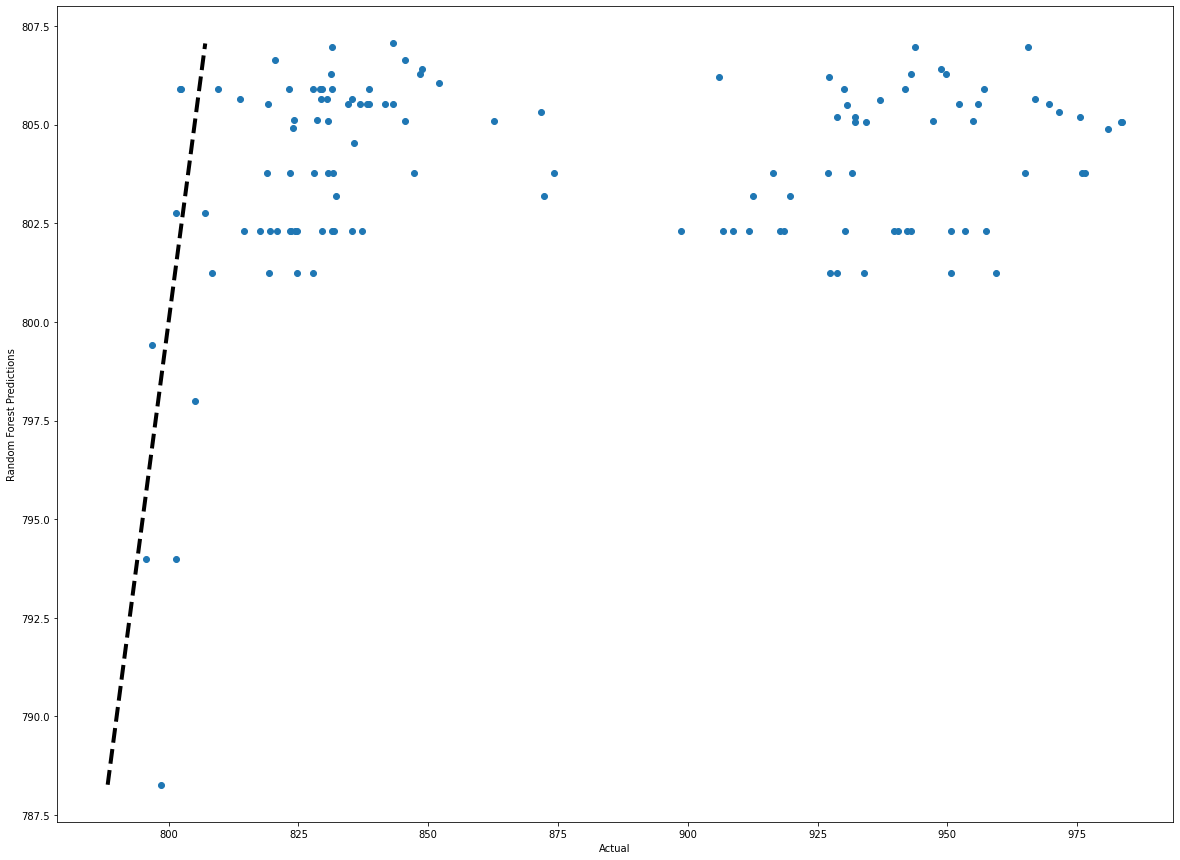




Random Forests Evaluation and scores for  AAPL

Train scores [0.9671353799751621, 0.9888962923525526, 0.9861242395921646]
Train Scores Mean 0.9807186373066265, Train Scores STD 0.009671253932011728

Test scores [0.5861787895580657, 0.8421452275679049, -4.903306825687271]
Test Scores Mean -1.1583276028537668, Test Scores STD 2.6501612201194904

Predictions [120.7279998 120.7039994 120.6059998 119.9559998 120.6239992 120.6859984
 121.1359984 121.1359984 120.8599992 120.7659992 122.7919984 122.7919984]

Actual [119.779999 120.       120.080002 119.970001 121.879997 121.940002
 121.949997 121.629997 121.349998 128.75     128.529999 129.080002]


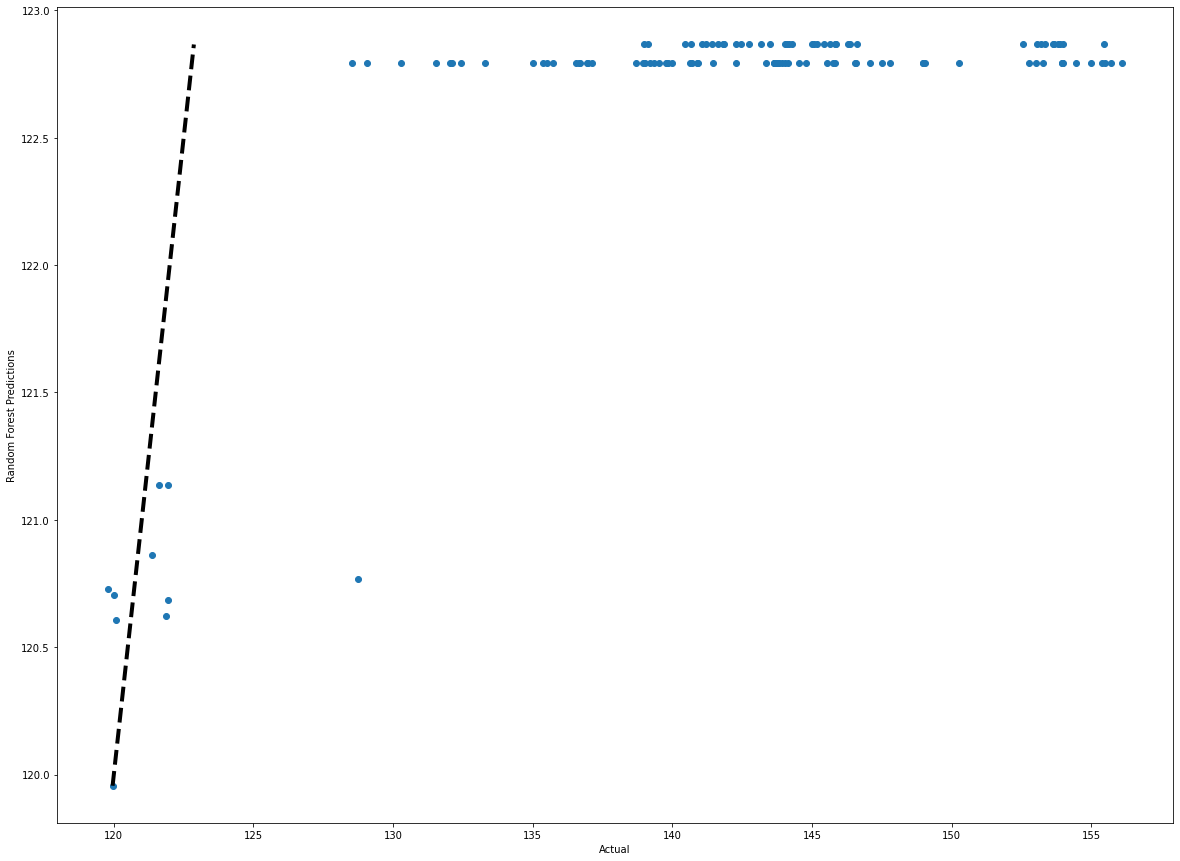

In [25]:
for symbol in tickers:
        
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)

    d = { 
        'BB_RATIOS' : get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
        'SMA_RATIOS' : get_sma_ratio(df_explore[symbol], window=metrics_window), 
        'MOMENTUM' : get_momentum(df_explore[symbol], window=metrics_window)
    }
    features_df = pd.DataFrame(d)

    X_features = features_df[0 : -1].values
    y_target = df_explore[symbol][(metrics_window + 1) : ].values

    clf_rf = RandomForestRegressor(n_estimators=5)
    tscv = TimeSeriesSplit(n_splits=3)

    train_scores = []
    test_scores = []

    final_predics = []
    actual_vals = []

    for train_index, test_index in tscv.split(X_features):
        clf_rf.fit(X_features[train_index], y_target[train_index])

        train_score = clf_rf.score(X_features[train_index], y_target[train_index])
        test_score = clf_rf.score(X_features[test_index], y_target[test_index])

        train_scores.append(train_score)
        test_scores.append(test_score)

        final_predic = clf_rf.predict(X_features[test_index])
        actual_vals = y_target[test_index]
    
    print ('Random Forests Evaluation and scores for ', symbol)
    print ('\nTrain scores', train_scores)
    print ('Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std()))

    print ('\nTest scores', test_scores)
    print ('Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std()))

    print ('\nPredictions', final_predic[0: 12])

    print ('\nActual', actual_vals[0: 12])

    plot_predictions(actual_vals, final_predic, y_label='Random Forest Predictions')
    print ('\n\n')